# Medication Dosage Prediction
### by Walid Rahman

# Medication Dosage and Frequency Predictions

### This notebook is a complete walkthrough of the data preprocessing, analysis, and machine learning model design used for the medication titration tool as part of my internship at Veta Health during Summer 2019. This is not the final version since I have saved the final version only for Veta Health. However, this notebook does demonstrate the general work. Also, please note that none of the data that is used in this notebook has been provided. That data can only be accessed by permission of MIT Lab for Computational Physiology. In order to access for the data, you need to [request access].(https://eicu-crd.mit.edu/gettingstarted/access/). Additionally, the method of implementation is not shown in this notebook since that is solely meant for Veta Health. 

####  This notebook shows the lowest performance achieved all iterations. However, it is meant to demonstrate how drug dosage and frequency can be predicted using clinical features. 


### Problem: 

Doctors regularly prescribe their patients medication even after they have left the hospital. The prescribing of those medications and the recommended frequencies is often based on factors such as pre-existing conditions, patient weight and height, age, and lab tests. However, it is often difficult to accurately prescribe a dosage and frequency of a medication for any patient. It is therefore of interest to design a machine learning based model to predict ideal medication dosages and frequencies. 

### Challenges: 

Clinical/patient data is often very difficult to come by. Due to the high level of security required to protect patient information and the risk associated with the identification of patients using their clinical information, most patient data found within EHRs is not publicly available. Additionally, most patient data is very sparse and often incomplete. There also exists the challenges associated with medical terminologies used to define various features of clinical data. The terminologies used are not always consistent. The incompleteness and sparsity of clinical data makes it extremely difficult to produce statistical models that can accurately make any predictions of any kind at all, let alone the prediction of ideal medication and dosage for a patient. 

### Solutions: 

Fortunately, there are some sources of clinical data available. The most well-known and widely used ones are the [MIMIC III critical care database](https://mimic.physionet.org) and the [eICU Collaborative Research Database](https://eicu-crd.mit.edu) curates by the Lab for Computational Physiology (LCP) at MIT. These two databases contains over 100 GB of patient data and is generously provided for free upon request. This data has been retrieved and used for the final modeling in this project. Prior to the availability of this data, other datasets were also used to make predictive models. Please refer to the the "Project Iterations" folder for those respective notebooks. You will find that those first iterations with those datasets were fairly unsuccessful.

Even though there is significant data available through the LCP, it is not always complete data. However, it does provide easy ways to combine tables in its relational database to get tables in which one can find data for individual de-identified patients such as which medications they take, their vitals, and some of the tests that were administered to them. After preprocessing the data, transforming it, it was successfully used to build a predictive model for drug dosage and frequency prediction. Although it doesn't provide consistent results from medication to medication, it is generally successful for multiple medications and is a great starting point upon which a preliminary medication titration product can be designed and deployed for use. 

### Dependencies:

All code found in this notebook has already been run. I have provided outputs of the results as I go through each bit of code. However, in order to rerun it and actually use it for more medication datasets, you will need the following on your machine, either locally or in a virtual environment. 

> Python 3.6

> Pandas

> Numpy

> Scikit-learn

> XGBoost (not Python wrapper version, actual XGBoost package)

> Tensorflow (2.0 is fine), Keras

> Matplotlib


***
***

### Import Dependacies

In [0]:
# Pandas
import pandas as pd

# This will enable us to display all columns and rows of a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# In some cases, an excessive amount of warnings appear. All warnings
# have been explored and none have any impact on models
import warnings

from collections import Counter

# All sklearn package methods needed
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score


# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Tensorflow, keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.utils import to_categorical

# Note that tensorflow and numpy might show some comptaibility issues. This is noted to be patched in a future update to tensorflow. It doesn't affect
# any of the neural network models. If you would like make the warnings disappear, rerun the entire code block.




***
***

### Load & View Dataset

In this section, we use the dataset acquired from the eICU database. This dataset, which represents the use of acetaminophen in a clinical setting, was queried with standard SQL (note: not legacy SQL) on Google's BigQuery console. Please refer to the "BigQuery SQL Files" folder for more information. Other drug's datasets can also be used for this purpose.Data loading was done using Pandas because Pandas allows us to easily see features (columns) and patient instances (rows) in a relational format usually referred to as a dataframe. It is very easy to query Pandas dataframes due to their relational format. Additionally, these dataframes work seamlessly with many machine learning (ML) packages like Sklearn and Tensorflow. They can also be made into numpy arrays if one so desires.

In [0]:
# Request user to type in filepath of dataset and store filepath in
# variable 'filepath'.

filepath = input("Please paste the filepath to the drug dataset here:  ")

Please paste the filepath to the drug dataset here:   /home/walidr/Downloads/large_fentanyl.csv


Now, we are going to load this dataset into a pandas dataframe. Please take some time to scroll through the dataframe. Each column is a feature and each row is a distinct timepoint for a patient. Here is a dictionary of what each column means according to [ICP's eICU data dictionary](https://eicu-crd.mit.edu/about/eicu/).

 - patientunitstayid: a globally unique identifier for each patient
 - patienthealthsystemstayid: a unique identifier for each unique stay of each unique visit of a patient to the hospital
 - gender: patient gender
 - age: patient age
 - ethnicity: patient ethnicity
 - hospitalid: key for identifying hospital at which patient was admitted
 - wardid: key for identifying which ward patient was in during visit to hospital
 - apacheadmissiondx: admission diagnosis for patient at particular stay
 - admissionheight: height of patient at time of admission
 - hospitaladmittime24: time in 24 hour format of the hospital admission
 - hospitaladmitoffset: number of minutes from unit admit time that the patient was admitted to the hospital
 - hospitaladmitsource: location from where the patient was admitted to the hospital
 - hospitaldischargeyear: year in which patient was discharged
 - hospitaldischargetime24: time in 24 hour format of when the hospital discharge event occurred
 - hospitaldischargeoffset: number of minutes from unit admit time that the patient was discharged from the hospital
 - hospitaldischargelocation: structured list of location where the patient was discharged to from the hospital 
 - hospitaldischargestatus: specifies patient’s condition upon leaving the hospital: Alive, Expired, or NULL
 - unittype: the unit in which the patient was admitted to
 - unitadmittime24: time in 24 hour format of when the unit admit event occurred 
 - unitadmitsource: location from where the patient was admitted
 - unitvisitnumber: identifies the visit number of the patient, i.e. if the patient’s hospital stay has multiple unit stays
 - unitstaytype: patient’s unit stay type: stepdown/other, readmit for undo, admit, pre-admit, transfer, readmit
 - admissionweight: weight of the patient upon admission
 - dischargeweight: weight of the patient upon discharge
 - unitdischargtime24: time in 24 hour format of when the unit discharge event occurred 
 - unitdischargeoffset: number of minutes from unit admit time that the patient was discharged from the unit
 - unitdischargelocation: list of locations where the patient was discharged to from the unit 
 - uniquepid: id for uniquepatient (similar to patientunitstayid, but not apparent in other tables)
 - medicationid: surrogate key for drug
 - drugorderoffset: number of minutes from unit admit time that the drug was ordered
 - drugstartoffset: number of minutes from unit admit time that drug was started
 - drugivadmixture: whether or not the drug was administered through an IV admixture
 - drugordercancelled: whether or not drug order was cancelled
 - drugname: name of the drug. Note that many time throughout the databse, a drug is referred to using either different names or different cases. This issue was resolved when querying the data.
 - drughiclseqno: HICL for drug
 - dosage: drug dosage
 - routeadmin: the picklist route of administration for the drug e.g.: IV (intravenous), IV - continuous infusion (intravenous), PO (oral), etc.
 - frequency: the picklist frequency with which the drug is taken 
 - loadingdose: the loading dose of the drug
 - prn: denotes whether the drug was prn or not (prescribed as needed)
 - drugstopoffset: number of minuts from the unit admit time that the drug was stopped
 - gtc: the NDDF GTC code associated with the drug
 - apacheapsvarid: surrogate key for APACHE APS (input) variables
 - intubated: set to 0 when not populated; set to 1 when the patient is intubated at the time of the worst ABG result
 - vent: set to 0 when not populated; set to 1 when the patient is ventilated at the time of the worst respiratory rate
 - dialysis: set to 0 when not populated; set to 1 when it is indicated that the patient is on dialysis
 - eyes: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s eyes value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 4
 - motor: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s motor value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 6
 - verbal: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s verbal value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 5
 - meds: set to NULL when not populated; set to 1 when “unable to score due to meds” is selected and no GCS score is available for the APACHE day; set to 0 when “unable to score due to meds” is not selected and a valid GCS score is set
 - urine: set to NULL when not present; set to the APACHE API’s summed 24 hour urine output value when present
 - wbc: set to NULL when not present; set to the APACHE API’s worst WBC (white blood count) lab value when present
 - temperature: set to NULL when not present; set to the APACHE API’s worst Celsius temperature value when present
 - respiratoryrate: set to NULL when not present; set to the APACHE API’s worst respiratory rate value when present
 - sodium: set to NULL when not present; set to the APACHE API’s worst sodium lab value when present
 - hearrate: set to NULL when not present; set to the APACHE API’s worst heart rate value when present
 - meanbp: set to NULL when not present; set to the APACHE API’s worst mean blood pressure value when present
 - ph: set to NULL when not present; set to the APACHE API’s pH value for the worst ABG data set when present
 - hematocrit: set to NULL when not present; set to the APACHE API’s worst Hct lab value when present
 - creatinine: set to NULL when not present; set to the APACHE API’s worst creatinine lab value when present
 - albumin: set to NULL when not present; set to the APACHE API’s worst albumin lab value when present
 - pao2: set to NULL when not present; set to the APACHE API’s PaO2 value for the worst ABG data set when present
 - pco2: set to NULL when not present; set to the APACHE API’s paCO2 value for the worst ABG data set when present
 - bun: set to NULL when not present; set to the APACHE API’s worst BUN lab value when present
 - glucose: set to NULL when not present; set to the APACHE API’s worst glucose lab value when present
 - bilirubin: set to NULL when not present; set to the APACHE API’s worst bilirubin lab value when present
 - fio2: set to NULL when not present; set to the APACHE API’s FiO2 value for the worst ABG data set when present
 
Not all of these features are relevant, completely filled out for each patient, or help us predict ideal drug dosages and frequencies. Thus a lot of preprocessing needs to take place.
 

In [0]:
# Using the read_csv method in Pandas, store the dataset inside the variable 'drugset'

drugset = pd.read_csv(filepath)

# Let us view the entire dataframe. Note that this a large dataframe, so the output
# is quite large.




In [0]:
# Data is not displayed on GitHub due to the agreement signed with the providers of the data to not disseminate the data.
display(drugset.head())

It is clear that not all features have integer or float values. Many features such as gender, ethnicity, and apacheadmissiondx, etc have categorical values. Additionally, there are many missing values (which are the NaNs) and values set to -1.0 (indicating that a test was never done to get that value). Since machine learning (ML) models depend on numerical values to produce predictions, these values need to be transformed or removed. More importantly, not all these features can provide insight as to what dosage and at what frequency a drug should be prescribed. Take for example, hospitaldischargeoffset. Such a value cannot be attained until the patient has left the hospital and is not available to a physician or care team when treating the patient. In the next steps, we need to preprocess this dataframe, transform the data, and filter it in order to get a usable dataset. This process encompasses the majority of this notebook, highlighting how the biggest challenge in using ML in healthcare is not necessarily the development of models, but the structuring of data. 

***

***

### Data Preprocessing and Transforming

In this section, we will preprocess the data. This means that we will study the data, remove parts of the data, or create new features. Explanations of each code block will be provided within the code blocks as comments.

In [0]:
# We will use the 'patientunitstayid' as the feature by which to count patients.
# Here we store unique patient stay ids inside a list. Then we print out the number 
# of unique patients, the number of rows in our dataframe, and the number of columns
# in our dataframe.
uniquePid = drugset['patientunitstayid'].unique().tolist()
print("Number of unique patients: " + str(len(uniquePid)))
print("Number of rows: " + str(drugset.shape[0]))
print("Number of columns: " + str(drugset.shape[1]))

Number of unique patients: 8880
Number of rows: 22786
Number of columns: 68


In [0]:
# Let us examine how many Null Values exist for each feature in our dataframe. This will help us determine which features 
# are worth keeping, and which other features can be extrapolated for a patient.

# Count number of nulls per columns
col_nasum_drugset = drugset.isna().sum()

# Make dictionary structure using column name and count of nulls
nan_dict_drugset = {'Column Name':col_nasum_drugset.index, 'Null Count':col_nasum_drugset.values}

# Make dataframe out of dictionary
nan_df_drugset = pd.DataFrame.from_dict(nan_dict_drugset)

# Alter the dataframe column names
nan_df_drugset.set_index('Column Name', inplace=True)

# Display dataframe
display(nan_df_drugset) 

,Null Count
Column Name,
patientunitstayid,0
patienthealthsystemstayid,0
gender,0
age,0
ethnicity,88
hospitalid,0
wardid,0
apacheadmissiondx,223
admissionheight,199


As we can see, some features have many datapoints missing. Since we don't want too many missing values in our entire dataframe, we should definitely remove features (columns) that have too many datapoints missing. We do this first, before removing rows that have too many nulls, in order to preserve as many rows as possible. It is better to remove features that are rarely filled in rather then entire patient datapoints that have some missing values.

In [0]:
# Store columns that have too many NANs into a list. We can specify the threshold
# of how many null values a column can have before it should be tossed. This value
# is decided by the user. I have chosen 125 since if we remove the frequency column
# of 125 null values, which is needed for this project, we can no longer do any
# dosage and freqeucny predictions. 
null_threshold = max(nan_df_drugset.loc['dosage', 'Null Count'] , nan_df_drugset.loc['frequency', 'Null Count'])
overmill = nan_df_drugset[nan_df_drugset['Null Count'] > null_threshold ]


# We store the index of 'overmill' since the index stores the column names

print('Must remove these columns: ')
remove_cols = list(overmill.index)
print(remove_cols)

Must remove these columns: 
['loadingdose']


In [0]:
# Now let us remove those columns. 

drugset = drugset.drop(columns = remove_cols)

In [0]:
# Now that we have removed columns with too many nulls, we can remove rows with 
# too many nulls.

drugset = drugset.dropna()
print("Patients in dataset remaining:  " + str(len(drugset['patientunitstayid'].unique().tolist())))

Patients in dataset remaining:  2538


Let us view the dataframe again, with a few datapoints shown for easy of viewing. There are many other columns that really don't give us useful predictive information. Some features like 'patienthealthsystemstayid' and 'uniquepid' actually give us redundant information: The patientunitstayid is already a unique patient identifier. We don't need the id for ML, but we should keep it for now to allow us to understand distinction between patients using an ID. The features: hospitalid, wardid, hospitaladmittime24, hospitaldischargeyear, hospitaldischargetime24, hospitaldischargelocation, hospitaldischargestatus, unittype, unitadmittime24, unitadmitsource, unitvisitnumber, unitstaytype, unitdischargetime24, unitdischargeoffset, unitdischargelocation, unitdischargestatus, uniquepid, drugordercancelled, drugname(since we know it is the same drug for all patients anyway), drughiclseqno, gtc, apacheapsvarid... can be removed.

In [0]:
# Store unwanted and unnecessary features inside a list
drop_list = [
             'patienthealthsystemstayid',
             'hospitalid', 
             'wardid', 
             'hospitaladmittime24', 
             'hospitaladmitoffset',
             'hospitaldischargeyear', 
             'hospitaldischargeoffset', 
             'drugorderoffset',
             'drugstartoffset',  
             'drugstopoffset',
             'hospitaldischargetime24', 
             'hospitaldischargelocation', 
             'hospitaldischargestatus', 
             'unittype', 
             'unitadmittime24', 
             'unitadmitsource', 
             'unitvisitnumber', 
             'unitstaytype', 
             'unitdischargetime24', 
             'unitdischargeoffset', 
             'unitdischargelocation', 
             'unitdischargestatus',
             'uniquepid', 
             'drugordercancelled', 
             'drugname', 
             'drughiclseqno', 
             'gtc', 
             'apacheapsvarid', 
             'medicationid'
            ]

# We can drop these columns by specifying the columns to be dropped as belong to the list we
# just made.
drugset = drugset.drop(columns = drop_list)
display(drugset.head()) # data not shown here for privacy reasons

Notice how our dataframe has much fewer columns now. However, scroll down the dataframe and you will find that many fields like 'albumin' and 'creatinine' hold far too many -1.0s. Although these columns are not null, they are effectively useless for the purpose of predicting dosage and frequency in our case. This information as is may be useful for other purposes. If the majority of these fields were filled with values other than -1.0 or null values, they could have definitely been more useful. We will later filter our dataset to remove these features. I didn't remove them with the other fields in the code block above because it is important to emphasize that they can definitely be useful for clinical purposes if they hold relevance in the way they are currently filled. 

In [0]:
# Note that there are multiple rows for many patients. This is redundant data. Although such a longitudinal 
# format is essential for EHRs, we don't want repeated patient data for our machine learning applications. We will drop
# duplicate patients and store their latest datapoint.

drugset = drugset.drop_duplicates(subset='patientunitstayid', keep='last')

In [0]:
# Note how some of the values in the dosage column have capitalized
# units while others don't. Since we will with dosage and frequency,
# let us standardize how those values appear by turning everything to
# lowercase. We will also get rid of excess white spaces in the 
# frequency column values.

drugset['frequency'] = drugset['frequency'].str.lower()
drugset['frequency'] = drugset['frequency'].str.replace(" ","")
drugset['dosage'] = drugset['dosage'].str.lower()

In [0]:
# Additionally, some of the age datapoints are not integers. We want to convert those to integers. In particular, some of 
# the ages are "> 89". Since we don't know the exact ages, we will simply convert their ages to 89. Ideally, we would
# have their exact ages.

drugset.loc[drugset.age == '> 89', 'age'] = 89

# Convert all ages to integers
drugset['age'] = drugset['age'].astype(int)

In [0]:
# Let us see all the unique dosages in our dataset and if they are all valid
print(drugset['dosage'].unique().tolist())

['50-100 mcg', '50 mcg', '25 mcg', '0 mcg', '100 mcg', '12.5 mcg', '75 mcg', '150 mcg', 'pyxis', 'manual charge', '250 mcg', '200 mcg', '50 mcg/hr', '25-200 mcg/hr', '1 mg', '2500 mcg', '125 mcg', '25 mcg/hr', '25-100 mcg', '500 mcg']


In [0]:
# Clearly not all of them are. 1 dose(s) isn't a dosage, and 0 mg or 0 is essentially not taking the medication. Similar with 1-2 tab. Let's remove rows with these
# dosages

unwanted_doseages = ['1 dose(s)','0 mg', '0', '1-2 tab', 'pyxis', '1 tab', 'manual charge', '0 mcg']
drugset = drugset[~drugset.dosage.isin(unwanted_doseages)]
print(drugset['dosage'].unique().tolist())

['50-100 mcg', '50 mcg', '25 mcg', '100 mcg', '12.5 mcg', '75 mcg', '150 mcg', '250 mcg', '200 mcg', '50 mcg/hr', '25-200 mcg/hr', '1 mg', '2500 mcg', '125 mcg', '25 mcg/hr', '25-100 mcg', '500 mcg']


In [0]:
# Some of the frequencies are the same even if they may be coded 
# differently. We need to change that. Let's see what the unique frequencies
# in our dataframe are.

print(drugset['frequency'].unique().tolist())

['every5minprn', 'q72h', 'every1hourprn', 'every2hoursprn', 'x1m1019', 'x1m779', 'x1m599', 'q2hr', 'every30minprn', 'q1hr', 'x1m839', 'q5minh4', 'every4hoursprn', 'every2hourprn', 'q1hp', 'onetime', 'x1m419', 'q5min', 'x1m359', 'x1m659', 'every3hoursprn', 'x1m539', 'x1m719', 'x1m1079', 'x1edm14', 'q4hr', 'onceasneededx1', 'one', 'once', 'oncex1', '.stk-med', 'asneeded', 'asdirected', 'titrated/seeadmininstructions', 'prnp', 'every8hoursprn', 'q2hp', 'q6hp', 'prn', 'every10minprn', 'q4hp', 'onceasneeded', 'x1m959', 'x1', 'ot', 'titrate']


In [0]:
# Looking at the list above, it is cleaer that q6h and q6hr are the same, q4h and q4hr are the same. So we will convert q4h to q4hr and q6h to q6hr.

drugset = drugset.replace({'frequency': {
    '6h ': 'q6hr',
    '6h':'q6hr',
    'q6h': 'q6hr',
    'q6':'q6hr',
    'q6hprn':'q6hr',
    'q6hrsprn':'q6hr',
    'every6hoursscheduled':'q6hr',
    'q4h':'q4hr',
    'q4hprn':'q4hr',
    'q4hrsprn':'q4hr',
    'q8hprn':'q8hr',
    'q8h':'q8hr',
    'q8hrs':'q8hr',
    'q8':'q8hr',
    '8h':'q8hr',
    'q8hour':'q8hr',
    'q3h':'q3hr',
    '.q10h':'q10hr',
    'q10h':'q10hr',
    'q12h':'q12hr',
    '12h':'q12hr',
    'q12':'q12hr',
    'q24h':'q24hr',
    'every12hoursscheduled':'q12hr',
    'every12hours':'q12hr',
    'every24hours':'q24hr',
    'onceperdayonmonwedfri':'q48hr',
    'q24hr(interval)':'q24hr',
    'q48h':'q48hr',
    'every other day':'q48hr',
    'mwf':'q48hr',
    'bid':'2xdaily',
    'bid(0917)':'2xdaily',
    'bidprn':'2xdaily',
    'bidp':'2xdaily',
    'bidmeals':'2xdaily',
    'q12hour(bid)':'2xdaily',
    'tidp':'3xdaily',
    'tid':'3xdaily',
    'tidprn':'3xdaily',
    'tid(091421)':'3xdaily',
    '3timesdaily':'3xdaily',
    'dailyx3':'3xdaily',
    'qid':'4xdaily',
    'bid(0618)':'2xdaily',
    'twiceaday':'2xdaily',
    '2timesdaily':'2xdaily',
    'bid7hour':'2xdaily',
    'bidac':'2xdaily',
    'bidx2':'2xdaily',
    '2timesdailyaftermeals':'2xdaily',
    'daily':'1xdaily',
    'one':'once', 
    'one1':'once',
    'oncex1':'once',
    'now':'once',
    'oto':'once',
    'ot':'once',
    '1x':'once',
    'x1':'once',
    'onetime':'once',
    'onetimeprn':'once',
    'qhsprn':'once',
    'oncerx':'once',
    'qday':'1xdaily',
    'qam':'1xdaily',
    'qhs(2100)':'1xdaily',
    'qpm':'q48hr',
    'dailypm':'1xdaily',
    'dailyprn':'1xdaily',
    'dailybreakfast':'1xdaily',
    'daily,daily':'1xdaily',
    'dailyearly':'1xdaily',
    'bedtime':'1xdaily',
    'everyevening':'1xdaily',
    '1xdailyhs':'1xdaily',
    'dailywithdinner':'1xdaily',
    'hs':'1xdaily',
    'nightly':'1xdaily',
    'dailyac':"1xdaily",
    'daily(0900)':'1xdaily',
    'daily(1700)':'1xdaily',
    'qhs':'1xdaily',
    'atbedtime':'1xdaily',
    'dailyd30':'1xdaily',
    'everymorningbeforebreakfast':'1xdaily',
    'dailyb':'1xdaily',
    'bid,twiceaday':'2xdaily',
    'dailyacb':'1xdaily',
    'every8hoursscheduled':'q8hr',
    'every8hoursprn':'q8hr',
    'every6hours':'q6hr',
    'q12hr(interval)':'q12hr',
    'q48hour':'q48hr',
    'dailybedtime':'1xdaily',
    'q72h':'q72hr',
    'q6hour':'q6hr',
    'every8hours':'q8hr',
    'dailyx1':'1xdaily',
    'tidac':'3xdaily',
    'bidx4':'4xdaily',
    'q4hour':'q4hr',
    'q2days':'q48hr',
    'every4hoursprn':'q4hr',
    'every2hoursprn':'q2hr',
    'every3hoursprn':'q3hr',
    'every1hourprn':'q1hr',
    'every30minprn':'q30min',
    'every10minprn':'q10min',
    'every2hourprn':'q2hr',
    'every5minprn':'q5min',
    'onceasneededx1':'once',
    'q5minh4':'q5min',
    'onetimeonetimestat':'once',
    'onetimeonetime':'once',
    'onetimestat':'once', 
    'every4hrprnroutine':'q4hr',
    'every6hoursprn':'q6hr',
    'q15minprn':'q15min',
    'q8hourprn':'q8hr',
    'q4hourprn':'q4hr',
    'q2hrsprn':'q2hr',
    'every12hoursprn':'q12hr',
    'q2hourprn':'q2hr',
    '3timesdailyprn':'3xdaily',
    'onceasneeded':'once',
    'q2h':'q2hr',
    'q2hprn':'q2hr',
    'onceprn':'once',
    'qidprn':'4xdaily',
    'q8hr(interval)':'q8hr',
    'q3hourprn':'q3hr',
    'q1hprn':'q1hr',
    'dailyasneeded':'1xdaily',
    '2timesdailyprn':'2xdaily',
    'onceprnx1':'once',
    'q3hprn':'q3hp',
    'q6hourprn':'q6hr',
    'q5minprn':'q5min',
    'q1hrsprn':'q1hr',
    'nightlyprn':'1xdaily',
    'q12hour':'q12hr',
    'q1hourprn':'q1hr',
    'q1h':'q1hr',
    'q15m':'q15min'
    
                                        }})

# confirm if changes have been made
print(drugset['frequency'].unique().tolist())

['q5min', 'q72hr', 'q1hr', 'q2hr', 'x1m1019', 'x1m779', 'x1m599', 'q30min', 'x1m839', 'q4hr', 'q1hp', 'once', 'x1m419', 'x1m359', 'x1m659', 'q3hr', 'x1m539', 'x1m719', 'x1m1079', 'x1edm14', '.stk-med', 'asneeded', 'asdirected', 'titrated/seeadmininstructions', 'prnp', 'q8hr', 'q2hp', 'q6hp', 'prn', 'q10min', 'q4hp', 'x1m959', 'titrate']


In [0]:
# We can see some frequencies that won't be useful for predictions, 
# particularly 'pyxis'. This frequency refers to the  BD Pyxis™ MedStation™ automated medication dispensing system,
# meaning that the frequency is determined by a machine.
#  We can definitely remove some others, such as 'preop', 'achs', and 
# 'bedtime'. However, those frequencies may be relevant since they 
# still provide some information regarding when to take the medication at hand. 

unwanted_frequencies = ['x1edm14', 'x1m659','x1m359','.disp','pyx1time','otcond','x1m719', 
                        'x1m839','0','x1m419','x1m1019','prnp','x1m779','stat','.stk-med','qdp','x1m599','x1m899','x1m539',
'x1m1139','x1m1079','perprotocol', 'x1m959','pyxis','preop','prn','ud','achs','asdirected', 'as-dir', 'drip', 'titrate', 'biddiure',
                        'seeadminnotes','continuous','userspecified', 'onceasneeded', 'asneeded', 'post-proconceprnx1', 'udp',
                        'intra-proconcex1', 'intra-proconce', 'oncall','x1cm359', 'ondem', 'titrated/seeadmininstructions', 'prnp', 'hsprn', 'q5m', 'pre-proconce',
                        'protocol', 'qhsmrp', 'q5minprnx3', 'pre-proconcex1'
                       ]

drugset = drugset[~drugset.frequency.isin(unwanted_frequencies)]
print(drugset['frequency'].unique().tolist())

['q5min', 'q72hr', 'q1hr', 'q2hr', 'q30min', 'q4hr', 'q1hp', 'once', 'q3hr', 'q8hr', 'q2hp', 'q6hp', 'q10min', 'q4hp']


In [0]:
# Let us see how many patients we have left now
print('There are ' + str(len(drugset)) + ' remaining patients in the dataset.')

There are 1469 remaining patients in the dataset.


#### Making a new feature: Dosage and Frequency combination

It is important to remember the task at hand when organizing data. We want to not only predict what dosage a patient recieves, we also want to predict at what frequency that drug dosage is prescribed. There are two primary ways to do this

1) Predict dosage, make a new dataset with those dosages, and then predict frequencies for those dosages. The issue with this method is that it may comound errors in prediction. For example, if our model incorrectly predicts a dosage, that incorrect prediction will propagate forwards to the prediction of the frequency for that dosage. This isn't necessarily bad. If we have a good prediction accuracy for dosages, then we may still have a good prediction accuracy for associated frequencies. However, with our small dataset of patients, this method may not work too well. 

2) Make a new feature in our existing dataframe that is a combination of dosage and frequency for each row/patient. This is the simplest and most ideal approach since it greatly simplifies the predictions. We won't propagate errors found in method (1) and we can make fairly good predictions even with our small dataset. 

We will go with approach 2. 

In [0]:
# We will call our new feature/column 'dosfre' and will simply be
# a string concatenation of the dosage and frequency columns.

drugset['dosfre'] = drugset['dosage'] + ' ' + drugset['frequency']

# Let us also see an example of what this results in
display(drugset[['dosage', 'frequency', 'dosfre']].head())

,dosage,frequency,dosfre
33,50-100 mcg,q5min,50-100 mcg q5min
39,50-100 mcg,q5min,50-100 mcg q5min
54,50-100 mcg,q5min,50-100 mcg q5min
56,50-100 mcg,q5min,50-100 mcg q5min
59,50-100 mcg,q5min,50-100 mcg q5min


In [0]:
# At this point in time, in order to preserve changes made to the original
# dataframe, I will store the dataframe in a new variable

data = drugset

#### Encoding categorical features

Remember how many of our features were categorical? Here, we will one-hot encode them. This means that the features will be divided and set as new features and their values in each row will be set to a 0 or 1 based on the patient belonging to that feature. For example, if we encode ethnicity, we will get new features, one for each ethnicity. If a patient is of ethncitity "Asian", their "Asian" field will be set to 1 and the other ethnicity field for that patient will be set to 0. 

Why do we want to encode categorical features in this manner in the first place? Why not just assign a seperate number to each category for which a patient is defined? The problem with setting different numbers for each unique category is that some categories will be more heavily weighed than others, even when there may be no such relationship between the categories in the dataframe. For example, if we assigned 0 to the "Asian" ethnicity and 3 to the "Caucasian" ethncity, we will be telling our models that the latter category is of a higher value than the former, even though no such relationship between the categories actually exist. One-hot encoding prevents this issue and assigns equal weight to each category. 

In [0]:
# One-hot-encoding

# gender
data['gender'] = pd.Categorical(data['gender'])
gender_enc = pd.get_dummies(data['gender'], prefix = 'gender')
data  = pd.concat([data, gender_enc], axis=1)

# ethnicity
data['ethnicity'] = pd.Categorical(data['ethnicity'])
ethnicity_enc = pd.get_dummies(data['ethnicity'], prefix = 'ethnicity')
data  = pd.concat([data, ethnicity_enc], axis=1)

# apacheadmissiondx
data['apacheadmissiondx'] = pd.Categorical(data['apacheadmissiondx'])
apacheadmissiondx_enc = pd.get_dummies(data['apacheadmissiondx'], prefix = 'apacheadmissiondx')
data  = pd.concat([data, apacheadmissiondx_enc], axis=1)


# drugivadmixture
data['drugivadmixture'] = pd.Categorical(data['drugivadmixture'])
drugivadmixture_enc = pd.get_dummies(data['drugivadmixture'], prefix = 'drugivadmixture')
data  = pd.concat([data, drugivadmixture_enc], axis=1)

# routeadmin
data['routeadmin'] = pd.Categorical(data['routeadmin'])
routeadmin_enc = pd.get_dummies(data['routeadmin'], prefix = 'routeadmin')
data  = pd.concat([data, routeadmin_enc], axis=1)

# prn
data['prn'] = pd.Categorical(data['prn'])
prn_enc = pd.get_dummies(data['prn'], prefix = 'prn')
data  = pd.concat([data, prn_enc], axis=1)

In [0]:
# Now let us look at the features of our dataframe. You will notice
# that so many new columns have been added. Our one-hot encoding was
# successful.

display(data.head())

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,hospitaladmitsource,admissionweight,dischargeweight,drugivadmixture,dosage,routeadmin,frequency,prn,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,dosfre,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,"apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema",apacheadmissiondx_Abdomen only trauma,apacheadmissiondx_Abdomen/extremity trauma,apacheadmissiondx_Abdomen/multiple trauma,apacheadmissiondx_Abdomen/pelvis trauma,apacheadmissiondx_Ablation or mapping of cardiac conduction pathway,"apacheadmissiondx_Abscess, neurologic","apacheadmissiondx_Abscess/infection-cranial, surgery for",apacheadmissiondx_Acid-base/electrolyte disturbance,apacheadmissiondx_Adrenalectomy,apacheadmissiondx_Alcohol withdrawal,apacheadmissiondx_Anaphylaxis,apacheadmissiondx_Anemia,"apacheadmissiondx_Aneurysm, abdominal aortic","apacheadmissiondx_Aneurysm, abdominal aortic; with dissection","apacheadmissiondx_Aneurysm, abdominal aortic; with rupture","apacheadmissiondx_Aneurysm, dissecting aortic","apacheadmissiondx_Aneurysm, thoracic aortic; with dissection","apacheadmissiondx_Aneurysm/pseudoaneurysm, other","apacheadmissiondx_Aneurysms, repair of other (except ventricular)","apacheadmissiondx_Angina, stable (asymp or stable pattern of symptoms w/meds)","apacheadmissiondx_Angina, unstable (angina interferes w/quality of life or meds are tolerated poorly)",apacheadmissiondx_Aortic and Mitral valve replacement,apacheadmissiondx_Aortic valve replacement (isolated),"apacheadmissiondx_Apnea, sleep",apacheadmissiondx_Appendectomy,"apacheadmissiondx_Arrest, respiratory (without cardiac arrest)","apacheadmissiondx_Arteriovenous malformation, surgery for","apacheadmissiondx_Arthritis, septic",apacheadmissiondx_Atelectasis,"apacheadmissiondx_Biopsy, brain","apacheadmissiondx_Biopsy, open lung","apacheadmissiondx_Bleeding, GI from esophageal varices/portal hypertension","apacheadmissiondx_Bleeding, GI-location unknown","apacheadmissiondx_Bleeding, lower GI","apacheadmissiondx_Bleeding, upper GI","apacheadmissiondx_Bleeding-upper GI, surgery for",apacheadmissiondx_Burr hole placement,"apacheadmissiondx_CABG alone, coronary artery bypass grafting","apacheadmissiondx_CABG alone, redo",apacheadmissiondx_CABG with aortic valve replacement,apacheadmissiondx_CABG with double valve repair/replacement,apacheadmissiondx_CABG with other operation,"apacheadmissiondx_CHF, congestive heart failure","apacheadmissiondx_CVA, cerebrovascular accident/stroke","apacheadmissiondx_Cancer, esophageal","apacheadmissiondx_Cancer, laryngeal","apacheadmissiondx_Cancer, lung","apacheadmissiondx_Cancer, oral/sinus, surgery for","apacheadmissiondx_Cancer, other GI","apacheadmissiondx_Cancer, pancreatic","apacheadmissiondx_Cancer, stomach","apacheadmissiondx_Cancer-colon/rectal, surgery for (including abdominoperineal resections)","apacheadmissiondx_Cancer-esophageal, surgery for (abdominal approach)","apacheadmissiondx_Cancer-laryngeal/tracheal, surgery for","apacheadmissiondx_Cancer-other GI tract, surgery for (i.e., hepatoma, gallbladder etc.)","apacheadmissiondx_Cancer-stomach, surgery for",apacheadmissiondx_Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System),apacheadmissiondx_Cardiomyopathy,"apacheadmissiondx_Cardiovascular medical, other","apacheadmissiondx_Cardiovascular surgery, other",apacheadmissiondx_Cellulitis and localized soft tissue infections,"apacheadmissiondx_Cellulitis and localized soft tissue infections, surgery for","apacheadmissiondx_Cerebrospinal fluid leak, surgery for",apacheadmissiondx_Cesarean section,"apacheadmissiondx_Chest pain, musculoskeletal","apacheadmissiondx_Chest p

In [0]:
# Let us also see a list of all the features available in the dataframe.
list(data.columns)

['patientunitstayid',
 'gender',
 'age',
 'ethnicity',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmitsource',
 'admissionweight',
 'dischargeweight',
 'drugivadmixture',
 'dosage',
 'routeadmin',
 'frequency',
 'prn',
 'intubated',
 'vent',
 'dialysis',
 'eyes',
 'motor',
 'verbal',
 'meds',
 'urine',
 'wbc',
 'temperature',
 'respiratoryrate',
 'sodium',
 'heartrate',
 'meanbp',
 'ph',
 'hematocrit',
 'creatinine',
 'albumin',
 'pao2',
 'pco2',
 'bun',
 'glucose',
 'bilirubin',
 'fio2',
 'dosfre',
 'gender_Female',
 'gender_Male',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema',
 'apacheadmissiondx_Abdomen only trauma',
 'apacheadmissiondx_Abdomen/extremity trauma',
 'apacheadmissiondx_Abdomen/multiple trauma',
 'apacheadmissiondx_Abdomen/pelvis trauma',
 'apacheadmissiondx_

 We need to keep one of these  columns and remove the others. We need to get rid of columns with too many -1.0 values now. The dosage and frequency columns can also be removed because they are stored in 'dosfre'. We can also remove the 'patientunitstayid' column since we know each row is a unique patient now. Finally, we will remove the original columns of categorical values we have already encoded since we will only use the one-hot encoded columns made from those columns.

In [0]:
# The features we care to keep is called 'column_space', We will subset
# the dataframe for those features. You can remove a feature just by commenting them out.
# Although one can slice the list of columns, I have opted to copy paste them from above so that I can 
# easily comment out features I don't want to use when experimenting with various datasets.

column_space = [
  'age', 
 'admissionheight', 
 'admissionweight', 
 'intubated', 
 'vent', 
 'dialysis', 
 'eyes', 
 'motor', 
 'verbal', 
 'meds', 
 'wbc', 
 'temperature', 
 'respiratoryrate', 
 'meanbp', 
'hematocrit',
 'creatinine',
 'albumin',
'gender_Female',
 'gender_Male',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema',
 'apacheadmissiondx_Abdomen only trauma',
 'apacheadmissiondx_Abdomen/extremity trauma',
 'apacheadmissiondx_Abdomen/multiple trauma',
 'apacheadmissiondx_Abdomen/pelvis trauma',
 'apacheadmissiondx_Ablation or mapping of cardiac conduction pathway',
 'apacheadmissiondx_Abscess, neurologic',
 'apacheadmissiondx_Abscess/infection-cranial, surgery for',
 'apacheadmissiondx_Acid-base/electrolyte disturbance',
 'apacheadmissiondx_Adrenalectomy',
 'apacheadmissiondx_Alcohol withdrawal',
 'apacheadmissiondx_Anaphylaxis',
 'apacheadmissiondx_Anemia',
 'apacheadmissiondx_Aneurysm, abdominal aortic',
 'apacheadmissiondx_Aneurysm, abdominal aortic; with dissection',
 'apacheadmissiondx_Aneurysm, abdominal aortic; with rupture',
 'apacheadmissiondx_Aneurysm, dissecting aortic',
 'apacheadmissiondx_Aneurysm, thoracic aortic; with dissection',
 'apacheadmissiondx_Aneurysm/pseudoaneurysm, other',
 'apacheadmissiondx_Aneurysms, repair of other (except ventricular)',
 'apacheadmissiondx_Angina, stable (asymp or stable pattern of symptoms w/meds)',
 'apacheadmissiondx_Angina, unstable (angina interferes w/quality of life or meds are tolerated poorly)',
 'apacheadmissiondx_Aortic and Mitral valve replacement',
 'apacheadmissiondx_Aortic valve replacement (isolated)',
 'apacheadmissiondx_Apnea, sleep',
 'apacheadmissiondx_Appendectomy',
 'apacheadmissiondx_Arrest, respiratory (without cardiac arrest)',
 'apacheadmissiondx_Arteriovenous malformation, surgery for',
 'apacheadmissiondx_Arthritis, septic',
 'apacheadmissiondx_Atelectasis',
 'apacheadmissiondx_Biopsy, brain',
 'apacheadmissiondx_Biopsy, open lung',
 'apacheadmissiondx_Bleeding, GI from esophageal varices/portal hypertension',
 'apacheadmissiondx_Bleeding, GI-location unknown',
 'apacheadmissiondx_Bleeding, lower GI',
 'apacheadmissiondx_Bleeding, upper GI',
 'apacheadmissiondx_Bleeding-upper GI, surgery for',
 'apacheadmissiondx_Burr hole placement',
 'apacheadmissiondx_CABG alone, coronary artery bypass grafting',
 'apacheadmissiondx_CABG alone, redo',
 'apacheadmissiondx_CABG with aortic valve replacement',
 'apacheadmissiondx_CABG with double valve repair/replacement',
 'apacheadmissiondx_CABG with other operation',
 'apacheadmissiondx_CHF, congestive heart failure',
 'apacheadmissiondx_CVA, cerebrovascular accident/stroke',
 'apacheadmissiondx_Cancer, esophageal',
 'apacheadmissiondx_Cancer, laryngeal',
 'apacheadmissiondx_Cancer, lung',
 'apacheadmissiondx_Cancer, oral/sinus, surgery for',
 'apacheadmissiondx_Cancer, other GI',
 'apacheadmissiondx_Cancer, pancreatic',
 'apacheadmissiondx_Cancer, stomach',
 'apacheadmissiondx_Cancer-colon/rectal, surgery for (including abdominoperineal resections)',
 'apacheadmissiondx_Cancer-esophageal, surgery for (abdominal approach)',
 'apacheadmissiondx_Cancer-laryngeal/tracheal, surgery for',
 'apacheadmissiondx_Cancer-other GI tract, surgery for (i.e., hepatoma, gallbladder etc.)',
 'apacheadmissiondx_Cancer-stomach, surgery for',
 'apacheadmissiondx_Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)',
 'apacheadmissiondx_Cardiomyopathy',
 'apacheadmissiondx_Cardiovascular medical, other',
 'apacheadmissiondx_Cardiovascular surgery, other',
 'apacheadmissiondx_Cellulitis and localized soft tissue infections',
 'apacheadmissiondx_Cellulitis and localized soft tissue infections, surgery for',
 'apacheadmissiondx_Cerebrospinal fluid leak, surgery for',
 'apacheadmissiondx_Cesarean section',
 'apacheadmissiondx_Chest pain, musculoskeletal',
 'apacheadmissiondx_Chest pain, unknown origin',
 'apacheadmissiondx_Chest thorax only trauma',
 'apacheadmissiondx_Chest/abdomen trauma',
 'apacheadmissiondx_Chest/extremity trauma',
 'apacheadmissiondx_Chest/multiple trauma',
 'apacheadmissiondx_Chest/spinal trauma',
 'apacheadmissiondx_Cholangitis',
 'apacheadmissiondx_Cholecystectomy/cholangitis, surgery for (gallbladder removal)',
 'apacheadmissiondx_Coma/change in level of consciousness (for hepatic see GI, for diabetic see Endocrine, if related to cardiac arrest, see CV)',
 'apacheadmissiondx_Complications of prev. peripheral vasc. surgery,surgery for (i.e.ligation of bleeder, exploration and evacuation of hematoma, debridement, pseudoaneurysms, clots, fistula, etc.)',
 'apacheadmissiondx_Complications of previous GI surgery; surgery for (anastomotic leak, bleeding, abscess, infection, dehiscence, etc.)',
 'apacheadmissiondx_Complications of previous open heart surgery (i.e. bleeding, infection etc.)',
 'apacheadmissiondx_Complications of previous open-heart surgery, surgery for (i.e. bleeding, infection, mediastinal rewiring,leaking aortic graft etc.)',
 'apacheadmissiondx_Cosmetic surgery (all)',
 'apacheadmissiondx_Cranial nerve, decompression/ligation',
 'apacheadmissiondx_Cranioplasty and complications from previous craniotomies',
 'apacheadmissiondx_Cystectomy for neoplasm',
 'apacheadmissiondx_Cystectomy, other reasons',
 'apacheadmissiondx_Defibrillator, automatic implantable cardiac; insertion of',
 'apacheadmissiondx_Diabetic hyperglycemic hyperosmolar nonketotic coma (HHNC)',
 'apacheadmissiondx_Diabetic ketoacidosis',
 'apacheadmissiondx_Diverticular disease',
 'apacheadmissiondx_Diverticular disease, surgery for',
 'apacheadmissiondx_Drug withdrawal',
 'apacheadmissiondx_Efffusion, pericardial',
 'apacheadmissiondx_Effusions, pleural',
 'apacheadmissiondx_Embolectomy (with general anesthesia)',
 'apacheadmissiondx_Embolus, pulmonary',
 'apacheadmissiondx_Emphysema/bronchitis',
 'apacheadmissiondx_Encephalitis',
 'apacheadmissiondx_Encephalopathies (excluding hepatic)',
 'apacheadmissiondx_Encephalopathy, hepatic',
 'apacheadmissiondx_Endarterectomy (other vessels)',
 'apacheadmissiondx_Endarterectomy, carotid',
 'apacheadmissiondx_Endocarditis',
 'apacheadmissiondx_Esophageal surgery, other',
 'apacheadmissiondx_Exenteration, pelvic-female',
 'apacheadmissiondx_Extremity only trauma',
 'apacheadmissiondx_Extremity only trauma, surgery for',
 'apacheadmissiondx_Extremity/face trauma',
 'apacheadmissiondx_Extremity/multiple trauma',
 'apacheadmissiondx_Extremity/multiple trauma, surgery for',
 'apacheadmissiondx_Face only trauma',
 'apacheadmissiondx_Face/multiple trauma',
 'apacheadmissiondx_Fistula/abscess, surgery for (not inflammatory bowel disease)',
 'apacheadmissiondx_Fracture-pathological, non-union, non-traumatic, for fractures due to trauma see Trauma',
 'apacheadmissiondx_Fusion-spinal/Harrington rods',
 'apacheadmissiondx_GI Abscess/cyst-primary, surgery for',
 'apacheadmissiondx_GI abscess/cyst',
 'apacheadmissiondx_GI medical, other',
 'apacheadmissiondx_GI obstruction',
 'apacheadmissiondx_GI obstruction, surgery for (including lysis of adhesions)',
 'apacheadmissiondx_GI perforation/rupture',
 'apacheadmissiondx_GI perforation/rupture, surgery for',
 'apacheadmissiondx_GI surgery, other',
 'apacheadmissiondx_GI vascular insufficiency',
 'apacheadmissiondx_GI vascular ischemia, surgery for (resection)',
 'apacheadmissiondx_Genitourinary medical, other',
 'apacheadmissiondx_Genitourinary surgery, other',
 'apacheadmissiondx_Graft, all other bypass (except renal)',
 'apacheadmissiondx_Graft, aorto-femoral bypass',
 'apacheadmissiondx_Graft, aorto-iliac bypass',
 'apacheadmissiondx_Graft, femoral-femoral bypass',
 'apacheadmissiondx_Graft, femoral-popliteal bypass',
 'apacheadmissiondx_Graft, removal of infected vascular',
 'apacheadmissiondx_Grafting, skin (all)',
 'apacheadmissiondx_Head only trauma',
 'apacheadmissiondx_Head/abdomen trauma',
 'apacheadmissiondx_Head/chest trauma',
 'apacheadmissiondx_Head/extremity trauma',
 'apacheadmissiondx_Head/face trauma',
 'apacheadmissiondx_Head/multiple trauma',
 'apacheadmissiondx_Head/pelvis trauma',
 'apacheadmissiondx_Head/spinal trauma',
 'apacheadmissiondx_Heat exhaustion/stroke',
 'apacheadmissiondx_Hematologic surgery, other',
 'apacheadmissiondx_Hematoma subdural, surgery for',
 'apacheadmissiondx_Hematoma, subdural',
 'apacheadmissiondx_Hematoma-epidural, surgery for',
 'apacheadmissiondx_Hematomas',
 'apacheadmissiondx_Hemorrhage (for gastrointestinal bleeding GI-see GI system) (for trauma see Trauma)',
 'apacheadmissiondx_Hemorrhage, intra/retroperitoneal',
 'apacheadmissiondx_Hemorrhage, postpartum',
 'apacheadmissiondx_Hemorrhage/hematoma, intracranial',
 'apacheadmissiondx_Hemorrhage/hematoma-intracranial, surgery for',
 'apacheadmissiondx_Hemorrhage/hemoptysis, pulmonary',
 'apacheadmissiondx_Hepatic failure, acute',
 'apacheadmissiondx_Hernia-hiatal, esophageal surgery for',
 'apacheadmissiondx_Herniorrhaphy',
 'apacheadmissiondx_Hip replacement, total (non-traumatic)',
 'apacheadmissiondx_Hypertension, uncontrolled (for cerebrovascular accident-see Neurological System)',
 'apacheadmissiondx_Hypoglycemia',
 'apacheadmissiondx_Hypovolemia (including dehydration, Do not include shock states)',
 'apacheadmissiondx_Hysterectomy for cancer with or without lymph node dissection',
 'apacheadmissiondx_Infarction, acute myocardial (MI)',
 'apacheadmissiondx_Infection/abscess, other surgery for',
 'apacheadmissiondx_Inflammatory bowel disease',
 'apacheadmissiondx_Laminectomy/spinal cord decompression (excluding malignancies)',
 'apacheadmissiondx_MI admitted > 24 hrs after onset of ischemia',
 'apacheadmissiondx_Mastectomy (all)',
 'apacheadmissiondx_Meningitis',
 'apacheadmissiondx_Metabolic/endocrine medical, other',
 'apacheadmissiondx_Metabolic/endocrine surgery, other',
 'apacheadmissiondx_Mitral valve repair',
 'apacheadmissiondx_Mitral valve replacement',
 'apacheadmissiondx_Monitoring, hemodynamic (pre-operative evaluation)',
 'apacheadmissiondx_Musculoskeletal medical, other',
 'apacheadmissiondx_Neoplasm, neurologic',
 'apacheadmissiondx_Neoplasm-cranial, surgery for (excluding transphenoidal)',
 'apacheadmissiondx_Neoplasm-spinal cord, surgery or other related procedures',
 'apacheadmissiondx_Nephrectomy for neoplasm',
 'apacheadmissiondx_Neurologic medical, other',
 'apacheadmissiondx_Neurologic surgery, other',
 'apacheadmissiondx_Neutropenia',
 'apacheadmissiondx_Obesity-morbid, surgery for',
 'apacheadmissiondx_Obstruction due to neoplasm ,surgery for; (with or without ileal-conduit)',
 'apacheadmissiondx_Obstruction due to nephrolithiasis, surgery for (with or without ileal-conduit)',
 'apacheadmissiondx_Obstruction-airway (i.e., acute epiglottitis, post-extubation edema, foreign body, etc)',
 'apacheadmissiondx_Obstruction/other, surgery for (with or without ileal conduit)',
 'apacheadmissiondx_Oophorectomy with or without salpingectomy with or without lymph node dissection',
 'apacheadmissiondx_Orthopedic surgery, other',
 'apacheadmissiondx_Overdose, alcohols (bethanol, methanol, ethylene glycol)',
 'apacheadmissiondx_Overdose, analgesic (aspirin, acetaminophen)',
 'apacheadmissiondx_Overdose, other toxin, poison or drug',
 'apacheadmissiondx_Overdose, sedatives, hypnotics, antipsychotics, benzodiazepines',
 'apacheadmissiondx_Overdose, street drugs (opiates, cocaine, amphetamine)',
 'apacheadmissiondx_Pancreatitis',
 'apacheadmissiondx_Pancreatitis, surgery for',
 'apacheadmissiondx_Pancytopenia',
 'apacheadmissiondx_Pelvis/hip trauma',
 'apacheadmissiondx_Pericardial effusion/tamponade',
 'apacheadmissiondx_Peritonitis',
 'apacheadmissiondx_Peritonitis, surgery for',
 'apacheadmissiondx_Pneumonia, aspiration',
 'apacheadmissiondx_Pneumonia, bacterial',
 'apacheadmissiondx_Pneumonia, other',
 'apacheadmissiondx_Pneumothorax',
 'apacheadmissiondx_Renal failure, acute',
 'apacheadmissiondx_Renal infection/abscess',
 'apacheadmissiondx_Renal neoplasm, cancer',
 'apacheadmissiondx_Respiratory - medical, other',
 'apacheadmissiondx_Respiratory surgery, other',
 'apacheadmissiondx_Restrictive lung disease (i.e., Sarcoidosis, pulmonary fibrosis)',
 'apacheadmissiondx_Rhabdomyolysis',
 'apacheadmissiondx_Rhythm disturbance (atrial, supraventricular)',
 'apacheadmissiondx_Rhythm disturbance (conduction defect)',
 'apacheadmissiondx_Rhythm disturbance (ventricular)',
 'apacheadmissiondx_Seizures (primary-no structural brain disease)',
 'apacheadmissiondx_Sepsis, GI',
 'apacheadmissiondx_Sepsis, cutaneous/soft tissue',
 'apacheadmissiondx_Sepsis, gynecologic',
 'apacheadmissiondx_Sepsis, other',
 'apacheadmissiondx_Sepsis, pulmonary',
 'apacheadmissiondx_Sepsis, renal/UTI (including bladder)',
 'apacheadmissiondx_Sepsis, unknown',
 'apacheadmissiondx_Shunts and revisions',
 'apacheadmissiondx_Skin surgery, other',
 'apacheadmissiondx_Spinal cord only trauma',
 'apacheadmissiondx_Spinal cord surgery, other',
 'apacheadmissiondx_Spinal/extremity trauma',
 'apacheadmissiondx_Spinal/multiple trauma',
 'apacheadmissiondx_Subarachnoid hemorrhage/arteriovenous malformation',
 'apacheadmissiondx_Subarachnoid hemorrhage/intracranial aneurysm',
 'apacheadmissiondx_Subarachnoid hemorrhage/intracranial aneurysm, surgery for',
 'apacheadmissiondx_TURP, transurethral prostate resection for cancer',
 'apacheadmissiondx_Tamponade, pericardial',
 'apacheadmissiondx_Thoracotomy for benign tumor (i.e. mediastinal chest wall mass, thymectomy)',
 'apacheadmissiondx_Thoracotomy for lung cancer',
 'apacheadmissiondx_Thoracotomy for lung reduction',
 'apacheadmissiondx_Thoracotomy for other malignancy in chest',
 'apacheadmissiondx_Thoracotomy for other reasons',
 'apacheadmissiondx_Thoracotomy for pleural disease',
 'apacheadmissiondx_Thoracotomy for thoracic/respiratory infection',
 'apacheadmissiondx_Thrombectomy (with general anesthesia)',
 'apacheadmissiondx_Thrombocytopenia',
 'apacheadmissiondx_Thrombosis, vascular (deep vein)',
 'apacheadmissiondx_Thrombus, arterial',
 'apacheadmissiondx_Thyroidectomy',
 'apacheadmissiondx_Tracheostomy',
 'apacheadmissiondx_Transphenoidal surgery',
 'apacheadmissiondx_Trauma medical, other',
 'apacheadmissiondx_Trauma surgery, other',
 'apacheadmissiondx_Vascular medical, other',
 'apacheadmissiondx_Vascular surgery, other',
 'apacheadmissiondx_Ventriculostomy',
 'apacheadmissiondx_Weaning from mechanical ventilation (transfer from other unit or hospital only)',
 'apacheadmissiondx_Whipple-surgery for pancreatic cancer',
 'drugivadmixture_No',
 'drugivadmixture_Yes',
 'routeadmin_Epidural',
 'routeadmin_IV',
 'routeadmin_IntraVENOUS',
 'routeadmin_Intravenous',
 'routeadmin_TD',
 'routeadmin_Topical',
 'prn_No',
 'prn_Yes',
 'dosfre'
]

data = data[column_space]

In [0]:
# Let us explore the different dosage frequency combinations possible. 
# Let us also see how many of each combination exists in our dataframe.

dosfre_counter = Counter(data['dosfre'])
dosfre_counter_df = pd.DataFrame(list(dosfre_counter.items()),
                      columns=['DosageFrequency','Count'])
display(dosfre_counter_df)

,DosageFrequency,Count
0,50-100 mcg q5min,224
1,50 mcg q72hr,3
2,25 mcg q72hr,2
3,25 mcg q5min,142
4,25 mcg q1hr,84
5,25 mcg q2hr,58
6,50 mcg q2hr,31
7,50 mcg q1hr,50
8,50 mcg q5min,189
9,12.5 mcg q1hr,9


#### Balancing the dataset
Notice how so many dosage frequency combinations have only one instance? Our dosage frequency combinations are heavily unbalanced due to this. Our ML models won't be able to make proper interepretations of the data and our models will skew all predictions towards drug frequency combinations most commonly appearing in our dataset.

The best way to deal with this issue is by selecting dosage frequency combinations above a certain threshold. Looking at the dataset, one can determine which dosage/frequency combinations have enough datapoints for making statistical models with. This is a matter of preference in this case. The smaller the number chosen, the more classes of combinations one will end up with. The number of each class can be entered below and a balanced dataset with an equal number of each class will be subsetted from the original dataset. Each class will have the number of examples as is chosen.

In [0]:
# Ask user what is the count they wish to use as the minimum for choosing labels
min_count = int(input('What is the minimum count of each label you want to keep?  '))


What is the minimum count of each label you want to keep?   142


In [0]:
# Subset dosfre dataframe to get dosage frequency combinations that have at least as many instances as chosen.
enough_count_df = dosfre_counter_df[dosfre_counter_df['Count'] >= min_count]
enough_count_dosefrecombinations = enough_count_df['DosageFrequency'].tolist()
en_count = len(enough_count_dosefrecombinations)

In [0]:
# Now we will subset the dataset for instances with these dosage-frequency combinations
data_balanced = data[data['dosfre'].isin(enough_count_dosefrecombinations)]

# Now we will sort the dataframe by the 'dosfre' column so dosage/frequency
# combinations of the same kind are grouped together.
data_balanced = data_balanced.sort_values(by=['dosfre'])

There is no inherit way in the pandas library to divide the dataset into groups of min_count. I have created a function that iteratively adds a count to the dataframe for each instance of a unique dosage-frequency combination. It should be noted that the "iterrows" method is not the most efficient, but it is the easiest way to iteratively modify rows of a pandas dataframe.

In [0]:
# This function will iteratively count each instance of each unique
# dosfre. This is useful because it will later allow us to subset an
# equal amount of the dosage frequency combinations we require. 


def unique_counter_maker(dataframe):
    data_balanced = dataframe
    doseholder = [] # holds dosfre values for troubleshooting (in case)
    data_balanced['dosecount'] = 0 # initialize dosecount to 0s
    counter = 0 # initialize counter
    current = '' # initialize current 
    for index, row in data_balanced.iterrows():
        if row['dosfre'] != current:
            counter = 1
            current = row['dosfre']
            doseholder.append(current)
            data_balanced.at[index,'dosecount'] = counter
        elif row['dosfre'] == current:
            counter += 1
            data_balanced.at[index,'dosecount'] = counter
    
    return data_balanced

In [0]:
# Use the function to add the counting column to the dataframe
data_balanced = unique_counter_maker(data_balanced)
display(data_balanced.head()) #data not shown due to privacy agreement signed with data providers

Now that we have a dataset that is both balanced and includes counts of each unique dosage frequency combination, we can subset the dataset for to get an equal number of each dosage frequency combination.

In [0]:
# Now that we have a count of dosage frequency combinations, we can
# take the selected amount of each combination from the dataframe.

# specify how many of each dosfre we want
samplesize = min_count

# create list from numbers 1 to samplesize (+1 because python doesn't include last value)
samplesize_list = list(range(1, samplesize+1)) 

# subset data_balanced for rows that are within the sample size provided
fin_bal = data_balanced[data_balanced['dosecount'].isin(samplesize_list)]

# Let us randomize the dataframe so we can minimize oversampling of one target
fin_bal = fin_bal.sample(frac=1) 

#fin_bal is our final dataframe.

In [0]:
# We should store our data into seperate parts, X and y. X will always hold features, and y will always hold labels.
# We drop dosfre and dosecount because dosfre is what we are trying to predict
# and dosecount is no longer relevant since we have already subsetted the dataframe

X_bal = fin_bal.drop(['dosfre', 'dosecount'], axis =1)

In [0]:
# When making the targets, y, we need to encode them again so that
# our machine learning models will be able to process them numerically.
# For this purpose, we won't one hot encode, but label encode to represent
# each different target a different number. 
y_bal = fin_bal['dosfre']
dos_fre_bal = fin_bal['dosfre'].unique().tolist()
le_bal = preprocessing.LabelEncoder() # initialize label encoder
le_bal.fit(dos_fre_bal) # fit to label encoder
y_tran_bal = le_bal.transform(y_bal) # make transformed y value targets

In [0]:
# Now, let us confirm that we have an equal amount of each target
# dosage frequency combination in our dataset. We can represent this as
# a dataframe

dosfre_counter_y = Counter(y_tran_bal)
dosfre_counter_y_df = pd.DataFrame(list(dosfre_counter_y.items()),
                      columns=['DosageFrequency_encoded','Count'])
display(dosfre_counter_y_df)

,DosageFrequency_encoded,Count
0,3,142
1,2,142
2,0,142
3,1,142
4,4,142


We can see above that we have unique dosage/frequency combinations in our final dataset. There are exactly the same number of each unique combination, allowing for (the chosen number for each class x number of classes) data points. Even if we don't have a lot of datapoints, we have managed to attain a completely balanced dataset. Originally, our dataset was very unbalanced, which some dosage frequency combinations only appearing once in the entire dataframe. However, now that we have a balanced dataset, our machine learning models will be able to 'learn' for each class or combination equally.

***

***

### Exploring the dataset

We can plot some histograms to explore the dataset among the features. Here, a few feature's histograms are plotted. 

Text(0.5, 0, 'Age')

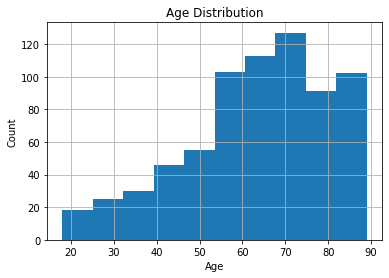

In [0]:
# Age distribution

X_bal['age'].hist()
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xlabel('Age')

Text(0.5, 0, 'Height')

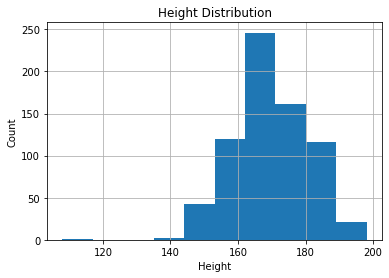

In [0]:
# height distribution

X_bal['admissionheight'].hist()
plt.title('Height Distribution')
plt.ylabel('Count')
plt.xlabel('Height')

Text(0.5, 0, 'Weight')

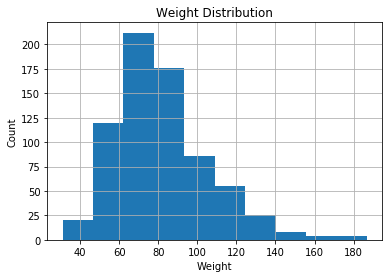

In [0]:
# Weight distribution

X_bal['admissionweight'].hist()
plt.title('Weight Distribution')
plt.ylabel('Count')
plt.xlabel('Weight')

Text(0.5, 0, 'WBC')

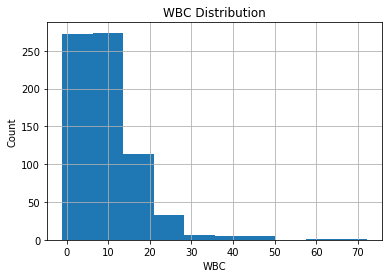

In [0]:
# WBC distribution

X_bal['wbc'].hist()
plt.title('WBC Distribution')
plt.ylabel('Count')
plt.xlabel('WBC')

Text(0.5, 0, 'Temperature')

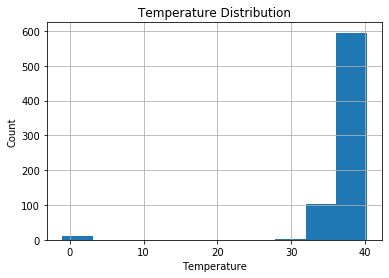

In [0]:
# temperature distribution

X_bal['temperature'].hist()
plt.title('Temperature Distribution')
plt.ylabel('Count')
plt.xlabel('Temperature')

Text(0.5, 0, 'Mean BP')

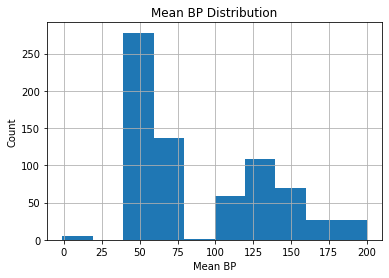

In [0]:
# Mean BP distribution

X_bal['meanbp'].hist()
plt.title('Mean BP Distribution')
plt.ylabel('Count')
plt.xlabel('Mean BP')

Plotting these features allows for the designing of cohorts based on these patient characteristics. Although this isn't explored for the purpose of medication titration, I have included these examples here to allude to the idea that various cohorts can be designed to balanced these features. We have balanced the dosage/frequency combinations. This is shown below.

Text(0.5, 0, 'Dosage/Frequency Combination')

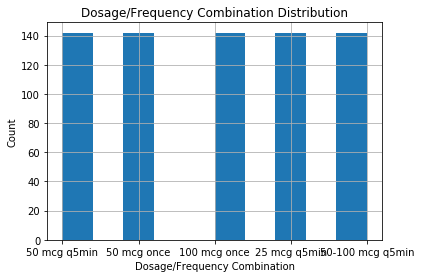

In [0]:
fin_bal['dosfre'].hist()
plt.title('Dosage/Frequency Combination Distribution')
plt.ylabel('Count')
plt.xlabel('Dosage/Frequency Combination')


***

***

### Machine Learning for Dosage/Frequency Prediction

After restructing our dataset and making it balanced, we can finallly start making predictions using machine learning. Machine learning will employ various model architectures to derive patterns in our data that can ultimately determine the actual dosage/frequency combination each patient recieved. Throughout the internship, I had access to various datasets which I balanced and tested multiple models on. I determined that there is really no one-model-fit solution to our problem. Instead, we must have test out multiple models and determine which model delivers the best predictions for our different dataset. This is because every drug interacts with the body in unique ways. This results in a new set of relationships between clinical features and between clinical features and actual dosages and frequencies. One issue with using so many models is that it is time consuming. I had initially tried out many different models, one at a time, thinking that with trial-and-error, I will eventually come across the best model for our problem. However, I discovered that it is better to perform some preliminary model testing. Therefore, I designed a function that applies seven different models to our data and determines the F1 score, Recall, Precision, and Accuracy of our predictions. These seven models are: 
>  [K Nearest Neighbors Classifier](https://scikitlearn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

>  [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 

>  [Logistic Regression Classifier](https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 

>  [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  

>  [Gaussian Naive-Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

>  [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) 

>  [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). 

One can use this function to determine which models are worth further improving and which models are not worth improving based on the results of the aforementioned metrics. 

However, I also used used two other models:

> [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) 

> [Neural Network with Keras](https://keras.io/)

XGBoost was used in a similar to the Graident Boosting Classifier since XGBoost is also gradient boosting. I have used both methodologies because the method with XGBoost allows for more parameter-tuning, which may lead to superior results with some datasets. The neurnal network implementation is also included because it sometimes performs similarly to the best models for any given dataset tested. The order of these models in this notebook is based on the order of the methodologies I tested. Any order can be followed. 

GridSearchCV: For all of these models, except for the neural network, I applied GridSearchCV. GridSearchCV goes through many different combinations of paramters before deciding on the ideal one. This will ensure that the model is finely tuned for each unique dataset.


It is important to note that this is a classification problem and not a regression one. We are trying to classify patients to their actual drug dosage and frequencies using the features we have determined as potentially useful. I have attempted regression with same datasets. However, the results with regression were very poor. The correlation coefficients between the features and targets are very small, making it difficult to use regression to predict ideal drug dosages. It also far more useful to treat this as a classification problem. In clinical practice, drug dosages are prescribed using the dosages avaiable on the market. Although it may be useful to get exact dosage amount to a few decimal places for a drug in some situations, it is far more relevant for the goal of the medication titration tool to predict what drug dosage a patient should recieve using the dosages available on the market. 

#### A note on metrics

Whereas with regression, one may use metrics such as mean squared error or mean absolute error to quantity the performance of their models, one uses other metrics with classification. As noted, we will be using the F1 score, recall, precision, and classification accuracy. These metrics revolve around counting the number of correct classifications and the number of incorrect classifications, and then relating those values to the rest of the classifications. For a in-depth overview of these metrics, refer to the following well written [article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2).

In our case:

* Precision: For each dosage/frequency combination (class), the number of correctly predicted classes out of all predictions for that class.

* Recall: For each dosage/frequency combination (class), the number of correct predictions out the actual number of instances belonging to that class.

* F1-Score: 2 × (precision × recall)/(precision + recall)

The precision, recall, and F1-score for each class is calculated after running our models and making predictions. Afterwards, a macro-average is performed for all the predictions. We do this because we have an equal amount of each class, since we balanced our dataset. We also perform the accuracy metric, just to show the number of accurate predictions out of all predictions. 

### Preliminary Model Testing

In [0]:
# This model accepts the features (X), the labels (y), the test size for train/test split, and a random_state if you choose to supply it.

def preliminary_testing(X, y, test_size, random_state=0):
    # Train test split with stratification of labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Initialize lists to hold models and metrics
    premodels = []
    model_names = []
    f1_scores = []
    recalls = []
    precisions = []
    accuracies = []
    
    # Initialize and add models to premodels list
    premodels.append(('K-NearestNeighbors', KNeighborsClassifier()))
    premodels.append(('SVC', SVC()))
    premodels.append(('LogisticRegression', LogisticRegression()))
    premodels.append(('DecisionTree', DecisionTreeClassifier()))
    premodels.append(('GaussianNaiveBayes', GaussianNB()))
    premodels.append(('RandomForest', RandomForestClassifier()))
    premodels.append(('GradientBoosting', GradientBoostingClassifier()))
    
    # Iteratively call each model and append metrics to corresponding lists
    for name, premodel in premodels:
        premodel.fit(X_train, y_train)
        y_pred = premodel.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        accuracies.append(accuracy_score(y_test, y_pred))
        model_names.append(name)
        
    # Make dataframe of each model's performance and return it    
    preliminary_test = pd.DataFrame({'Model Name': model_names, 'F1-Score': f1_scores, 'Recall':recalls, 'Precision':precisions, 'Accuracy':accuracies})
    return preliminary_test

In [0]:
prelims = preliminary_testing(X_bal, y_tran_bal, 0.33, 42)
display(prelims)

/home/walidr/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/walidr/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/walidr/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/walidr/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarn

,Model Name,F1-Score,Recall,Precision,Accuracy
0,K-NearestNeighbors,0.226269,0.225532,0.233400,0.225532
1,SVC,0.218901,0.221277,0.221617,0.221277
2,LogisticRegression,0.555753,0.561702,0.552158,0.561702
3,DecisionTree,0.564489,0.565957,0.573762,0.565957
4,GaussianNaiveBayes,0.501965,0.531915,0.521868,0.531915
5,RandomForest,0.517755,0.527660,0.523885,0.527660
6,GradientBoosting,0.545886,0.544681,0.551875,0.544681


### Individual Models

#### Decision Tree Classifier

In [0]:
# Split our dataset into training set and testing set
# The stratify parameter will ensure we have equal ratios of each label in both the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
# Prevent extensive outpouring of warnings I have already address while
# testing this code
warnings.filterwarnings('ignore')

# Initialize decision tree classifier
dt_clf = DecisionTreeClassifier()

# Specify parameters for GridSearchCV. GridSearchCV will test out all these paramters iteratively and we can then use
# the best combination of these parameters.
depths = np.arange(1, 10)
num_leafs = [1, 5, 10, 20, 30, 40]
max_features = np.arange(1, len(X_train.columns))
param_grid = [{'min_samples_split': range(2, 10),
               'max_depth':depths,
               'min_samples_leaf':num_leafs,
               'max_features' : max_features}]

# Initialize the classifier with the paramaters and cross validation 
dt_clf_cv = GridSearchCV(DecisionTreeClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1_macro')

# Start Training!
dt_clf_cv.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,


In [0]:
# Now let us store those parameters into our model and train again using that model
best_clf_tree_model = dt_clf_cv.best_estimator_
best_clf_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=158, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
# We can see a chart of all the feature importances
importances_dict_dtc = dict(zip(X_bal.columns, best_clf_tree_model.feature_importances_))
dtc_imp_df = pd.DataFrame(list(importances_dict_dtc.items()),
                      columns=['Feature','Importance'])
display(dtc_imp_df)

,Feature,Importance
0,age,0.000000
1,admissionheight,0.000000
2,admissionweight,0.019369
3,intubated,0.000000
4,vent,0.000000
5,dialysis,0.000000
6,eyes,0.000000
7,motor,0.000000
8,verbal,0.068271
9,meds,0.000000


In [0]:
# Let's make a prediction and calculate the f1-score, recall, and precision.
y_clf_pred = best_clf_tree_model.predict(X_test)

# We need to convert those predictions into actual dosage/frequency combinations by using the encoder we previously made
pred_names_dtc = le_bal.inverse_transform(y_clf_pred)

# Print results
print("F1 Score is: " + str(f1_score(y_test, y_clf_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_clf_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_clf_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, y_clf_pred)))


F1 Score is: 0.6020368050173093
Recall is: 0.6085106382978724
Precision is: 0.600992992992993
Accuracy is: 0.6085106382978723


In [0]:
# Let us table the predictions vs the actual values for dosage/frequency combinations
estimated_decisions = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_dtc}
pred_summary = pd.DataFrame.from_dict(estimated_decisions)
display(pred_summary)

,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,25 mcg q5min
1,50 mcg once,50 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,25 mcg q5min
4,25 mcg q5min,25 mcg q5min
5,100 mcg once,50 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,50 mcg q5min
8,100 mcg once,100 mcg once
9,50-100 mcg q5min,50-100 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_dtc, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.500     0.468     0.484        47
    25 mcg q5min      0.540     0.574     0.557        47
     50 mcg once      0.500     0.532     0.515        47
    50 mcg q5min      0.595     0.468     0.524        47
50-100 mcg q5min      0.870     1.000     0.931        47

        accuracy                          0.609       235
       macro avg      0.601     0.609     0.602       235
    weighted avg      0.601     0.609     0.602       235



The Decision Tree Classifier (DTC) takes a very long time to run. The performance of the classifier will depend on the random_state, the number of samples (size of our dataset), and the train/test split. Some of these factors influence each other. For example, the choice of random_state can impact the results, but the influence of the random_state on the results will vary due to the size of the entire dataset and the size of the set that the model trains on after splitting the original data into a testing set and training set. This is because random_state will specify how the data is split into training and test set and in what order the data is split. Between two different random states, a data point may appear in either the training set of the test set. This is not so much an issue if we have thousands of data points to work with. The variablity in results will decrease the more data points we have and the confidence interval of our results will decrease. Additionally, the amount of data points per dosage/frequency combination will impact how well the classifier can predict for a combination. 

Throughout the rest of this notebook, I have tried different random states for different models as well as the same random state for each model. When it came to using a small number of samples or datapoints, I chose the random state that yielded the best results. Otherwise, if I have a sufficiently large dataset, I can randomly pick a set random state and allow the models to run without worry about performance changing between random states.

#### XGBoost Classification

In [0]:
# Split our dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)


In [0]:
# Run XGBoost. You can change these parameters at any time before running.
data_xgb_c = xgb.DMatrix(data=X_train, label=y_train)
nc = len(np.unique(y_tran_bal)) #s specifying the number of classes

# Feel free to decide which parameters you want to include. Easy method is to comment out parameters you no longer want to use. 
xgb_params = {
    "eta": 0.001,
    "subsample": 0.9,
    "colsample_bytree": 0.95,
    "colsample_bylevel": 0.95,
    "colsample_bynode": 0.95,
    "tree_method":'hist',
    'grow_policy':'lossguide',
    "max_depth": nc+1,
    "objective": "multi:softmax", # important to specify this objective function for multi-class classification
    "num_class": nc+1,
    "eval_metric": "merror", # multi-class classification error rate
    "early_stopping_rounds": 600,
    "seed": 42 # parameter similar to random_state
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data_xgb_c, num_boost_round=600)
cv_history = xgb.cv(params=xgb_params, dtrain=data_xgb_c, num_boost_round=600, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=True),
                               xgb.callback.early_stop(600)])

XGBoost allows us to plot the importance of each feature. We can plot the gain, weight, and coverage of each feature. Refer to the following link for a good explanation of each: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7.

In our case, the gain tells us which features are most important for the classification of a patient to a dosage/frequency prediction. This will be the chart most useful to physicians.

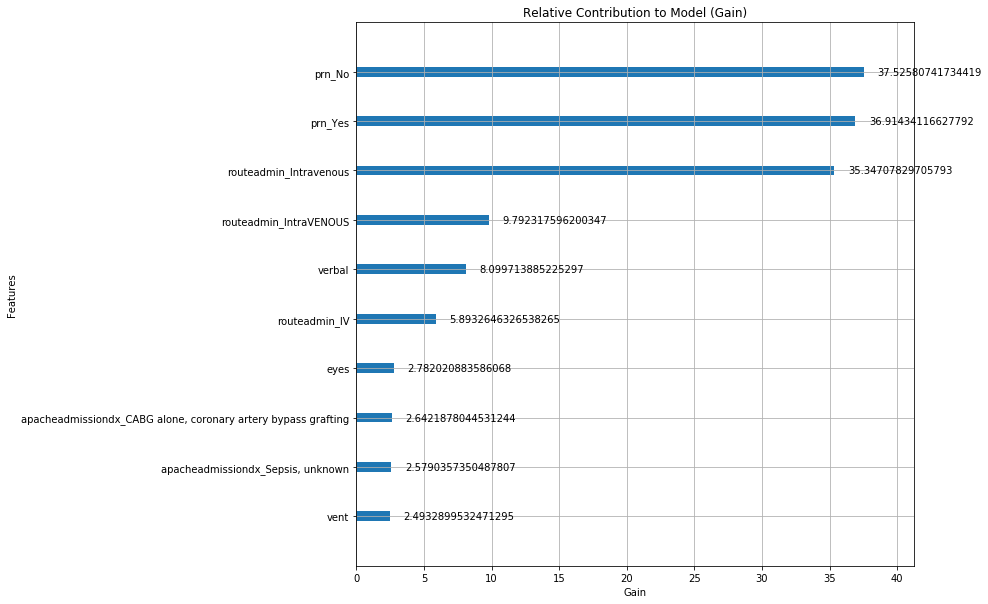

In [0]:
# Let us see which features are most important for classification
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgbmodel,importance_type='gain', title='Relative Contribution to Model (Gain)', xlabel = 'Gain', max_num_features = 10, ax=ax)

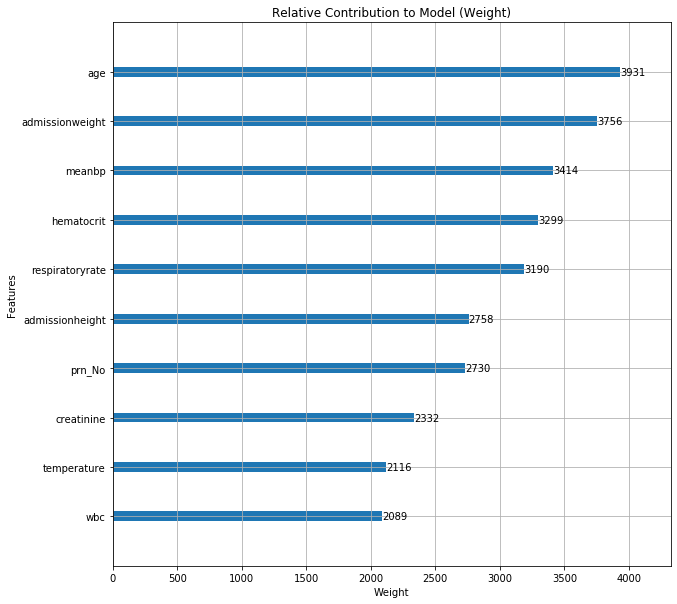

In [0]:
# Weight will show us the relative number of times a particular feature occurs in the trees of the model
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgbmodel,importance_type='weight', title='Relative Contribution to Model (Weight)', max_num_features = 10, xlabel = 'Weight', ax=ax)

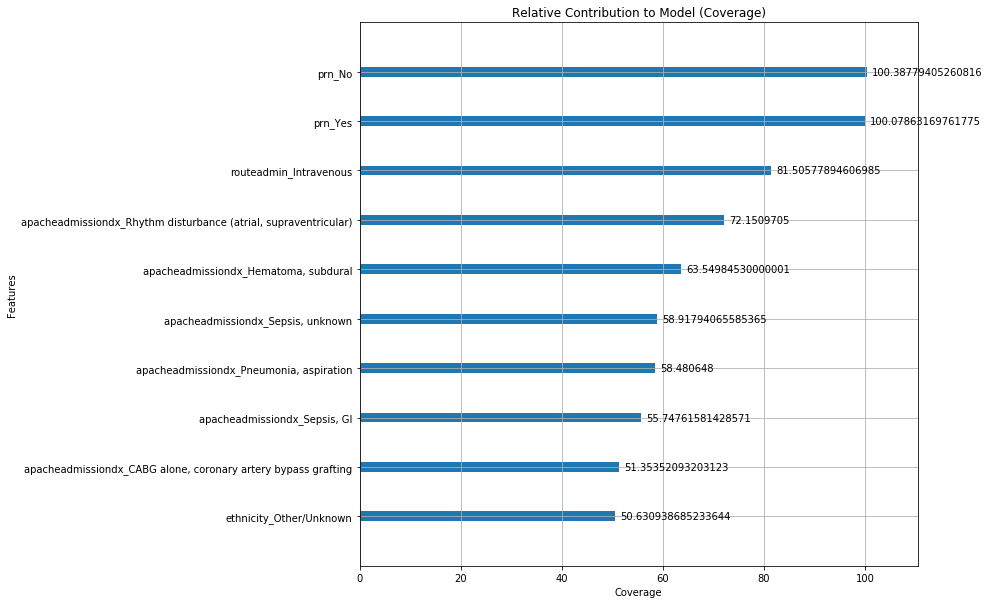

In [0]:
# Coverage will show us the relative number of observations related to each feature
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgbmodel,importance_type='cover', title='Relative Contribution to Model (Coverage)', max_num_features = 10, xlabel = 'Coverage', ax=ax)

In [0]:
# Let us make predictions
y_test_pred_c = xgbmodel.predict(xgb.DMatrix(X_test))
y_test_pred_c_int = [int(i) for i in y_test_pred_c]
pred_names_xgb = le_bal.inverse_transform(y_test_pred_c_int)


In [0]:
# Let us see how our model did
print("F1 Score is: " + str(f1_score(y_test, y_test_pred_c, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_test_pred_c, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_test_pred_c, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, y_test_pred_c)))

F1 Score is: 0.5773944762353658
Recall is: 0.5829787234042553
Precision is: 0.5798600858783229
Accuracy is: 0.5829787234042553


In [0]:
# Output dataframe comparing actual values and predicted values for comparison
estimated_decisions_xgb = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_xgb}
pred_summary = pd.DataFrame.from_dict(estimated_decisions_xgb)
display(pred_summary)

,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,50 mcg q5min
1,50 mcg once,50 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,25 mcg q5min
4,25 mcg q5min,50 mcg q5min
5,100 mcg once,100 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,25 mcg q5min
8,100 mcg once,50 mcg once
9,50-100 mcg q5min,25 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_xgb, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.500     0.362     0.420        47
    25 mcg q5min      0.511     0.489     0.500        47
     50 mcg once      0.500     0.638     0.561        47
    50 mcg q5min      0.511     0.511     0.511        47
50-100 mcg q5min      0.878     0.915     0.896        47

        accuracy                          0.583       235
       macro avg      0.580     0.583     0.577       235
    weighted avg      0.580     0.583     0.577       235



XGBoost is a tree-based model like the DTC. However, XGBoost generally performs better amongst all the medication datasets used. It uses gradient boosting. In order to get a general understanding of gradient boosting, refer to this [article](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/). 

XGBoost parameters can be tuned to improve the performance, but I have settled on the paramters shown here. Varying the parameters, particularly the learning rate, has shown to change the F1 score by +/- .2 based on the dataset.

The various feature importance plots offer some interpretability to physicians regading how the model works. The gain suggets which features were most important in the classification of patients to a particular dosage or frequency. The other two plots, weight and coverage, offers some insight into how many times the features appear in a deicision process and the relative number of occurences of a feature in the model, respectively.

#### Python Wrapper XGBoost Classifier

IMPORTANT: Here, I demonstrate XGBoost using GridSearchCV. Only run these code blocks if you have enough time run this model. This process can take 6+ hours to complete, depending on the configuration of your machine. I highly suggest using the Sklearn Gradient Boosting Classifier or just manually change paramters on XGBoost above. However, if you decide to be more throughput, use this model.

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
# Grid of parameters
param_grid = {
        'learning_rate':[.0001, .001, .01],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.75, 1.0],
        'colsample_bytree': [0.5, 0.75, 1.0],
        "colsample_bylevel": [0.5, 0.75, 1.0],
        "colsample_bynode": [0.5, 0.75, 1.0],
        'max_depth': [3, 6, 9],
        }

# Initialize the classifier with necessary paramters
xgboostc = XGBClassifier(n_estimators=100, objective="multi:softmax", num_class=nc+1, eval_metric='merror')

# GridSearchCV on model
xgboostc_cv = GridSearchCV(xgboostc,
              param_grid=param_grid,
              cv=3, scoring='f1_macro', verbose=2)

# Train model
xgboostc_cv.fit(X_train, y_train)

In [0]:
# Make predictions on best parameters determined by GridSearchCV
best_clf_xgboostc = xgboostc_cv.best_estimator_
best_clf_xgboostc.fit(X_train, y_train)

In [0]:
# Test Accuracy
xgboostc_pred = best_clf_xgboostc.predict(X_test)
pred_names_xgboostc = le_bal.inverse_transform(xgboostc_pred)
print("F1 Score is: " + str(f1_score(y_test, xgboostc_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, xgboostc_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, xgboostc_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, xgboostc_pred)))

estimated_decisions_xgboostc = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_xgboostc}
pred_summary_xgboostc = pd.DataFrame.from_dict(estimated_decisions_xgboostc)
display(pred_summary_xgboostc)

In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_xgboostc, digits=3))

### Scikit Learn XGBClassifier

This is the same as XGBoost, but using the version in the XGBClassifier class from Sklearn.

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
# Feel free to add parameters from the documentation. The parameters here are the ones I have settled on changing after testing on multiple datasets.
param_grid = {
        'learning_rate':[.0001, .001, .01],
        'subsample': [0.5, 0.75, 1.0],
        'max_depth': [3, 6, 10],
        'max_features':['auto', 'sqrt', 'log2', None]
        }

    
# Initialize the classifier with the paramaters and cross validation 
xgbc_clf_cv = GridSearchCV(GradientBoostingClassifier(n_estimators=600),
              param_grid=param_grid,
              cv=3, scoring='f1_macro', verbose=3)

# Train
xgbc_clf_cv.fit(X_train, y_train)

In [0]:
# Make predictions on best parameters determined by GridSearchCV
best_clf_xgbc = xgbc_clf_cv.best_estimator_
best_clf_xgbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
# Test Accuracy
xgbc_pred = best_clf_xgbc.predict(X_test)
pred_names_xgbc = le_bal.inverse_transform(xgbc_pred)
print("F1 Score is: " + str(f1_score(y_test, xgbc_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, xgbc_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, xgbc_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, xgbc_pred)))


estimated_decisions_xgbc = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_xgbc}
pred_summary_xgbc = pd.DataFrame.from_dict(estimated_decisions_xgbc)
display(pred_summary_xgbc)

F1 Score is: 0.555909866151812
Recall is: 0.5574468085106383
Precision is: 0.5555616605616606
Accuracy is: 0.5574468085106383


,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,50 mcg q5min
1,50 mcg once,100 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,25 mcg q5min
4,25 mcg q5min,50 mcg q5min
5,100 mcg once,100 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,25 mcg q5min
8,100 mcg once,50 mcg once
9,50-100 mcg q5min,50 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_xgbc, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.452     0.404     0.427        47
    25 mcg q5min      0.489     0.468     0.478        47
     50 mcg once      0.462     0.511     0.485        47
    50 mcg q5min      0.458     0.468     0.463        47
50-100 mcg q5min      0.917     0.936     0.926        47

        accuracy                          0.557       235
       macro avg      0.556     0.557     0.556       235
    weighted avg      0.556     0.557     0.556       235



### Neural Network

In [0]:
# Reinitialize the label encoder again because Keras requires the labels to be set to categorical values to be used 
# in the model. After that, train/test split again.
random_state_choice = 42
test_size_choice = 0.1
le_bal = preprocessing.LabelEncoder()
le_bal.fit(dos_fre_bal)
y_tran_bal = le_bal.transform(y_bal) 
y_tran_bal_cat = to_categorical(y_tran_bal)
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal_cat, test_size=test_size_choice, random_state=random_state_choice, 
                                                    stratify=y_tran_bal
                                                   )

In [0]:
# We will use the sequential model as we can simply stack layers onto the model. The format below allows for many layers to be added
# with various number of units. You can comment out layers to ensure they are not in the model. 

model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(X_bal.shape[1],))) 
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
# model.add(Dense(2, activation='tanh'))
model.add(Dropout(0.05))

# As we are doing multiclass classification, we will require the final layer to be a softmax activation function. 
model.add(Dense(y_train.shape[1], activation='softmax')) #Additional layer with softmax activation function
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='categorical_crossentropy', #Multiclass classification loss
              metrics=['categorical_accuracy'])

print("These are the layers of the model:")
model.summary()

These are the layers of the model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               36992     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout (Dropout)    

In [0]:
# We can use early stopping to stop training when we begin to decrease in accuracy. I also pass patience to allow for small decreases
# before sharp increase in accuracy
es = EarlyStopping(monitor='val_categorical_accuracy', mode='min', verbose=0, 
                   patience=10001
                  )
batch_size = 32

# Save best model (will be saved in same directory location)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

In [0]:
# Run model
run_model = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test), 
                      epochs=1000, verbose=2, 
                      callbacks=[es, mc]
                   )

# Print results of model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Plot training history of model
plt.plot(run_model.history['loss'], label='train')
plt.plot(run_model.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# Since the training and test set was made use the categorical labels, we need to remake the training and testing set
# It is important to use the same split and random_state as before, otherwise we will test on data points we have already trained for.
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=test_size_choice, random_state=random_state_choice, 
                                                    stratify=y_tran_bal
                                                   )

In [0]:
# Make Predictions after loading model
model.load_weights('best_model.h5')

y_keras = model.predict_classes(X_test)
pred_names_keras = le_bal.inverse_transform(y_keras)

# Print results
print("F1 Score is: " + str(f1_score(y_test, y_keras, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_keras, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_keras, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, y_keras)))


estimated_decisions_knn = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_keras}
pred_summary = pd.DataFrame.from_dict(estimated_decisions_knn)
display(pred_summary)

F1 Score is: 0.6871063877642825
Recall is: 0.7161904761904763
Precision is: 0.7196078431372549
Accuracy is: 0.7183098591549296


,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,50 mcg q5min
1,50 mcg once,50 mcg once
2,25 mcg q5min,50 mcg q5min
3,50 mcg q5min,50 mcg q5min
4,25 mcg q5min,50 mcg q5min
5,100 mcg once,50 mcg once
6,50 mcg once,50 mcg once
7,25 mcg q5min,25 mcg q5min
8,50 mcg q5min,50 mcg q5min
9,100 mcg once,50 mcg once


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_keras, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.500     0.143     0.222        14
    25 mcg q5min      0.833     0.714     0.769        14
     50 mcg once      0.500     0.857     0.632        14
    50 mcg q5min      0.765     0.867     0.812        15
50-100 mcg q5min      1.000     1.000     1.000        14

        accuracy                          0.718        71
       macro avg      0.720     0.716     0.687        71
    weighted avg      0.720     0.718     0.689        71



Neural networks take our dataset as a set of vectors, performs operations on them at each layer to attain a classification, and then backpropagates through the layers to adjust weights that were made to achieve the classification. This process is done every epoch, with the goal of minimizing the loss, or difference, between the real classification and predicted classification. 

Neural Networks generally perform very well with a large amount of data points. With smaller datasets like ours, the performance of the model is significantly reduced. The choice of activation function also greatly impacts the performance the model. Out of the three common ones: relu, tanh, and sigmoid, I have found tanh to provide the best results. Relu often provides the worst results, sigmoid provides mediocre results, and tanh consistently provides the best results. The most number of iterations needed before the network settles at constant loss was 2000. I have also found that the number of layers greatly impacts the performance for each different medication dataset required. This means that with one medication dataset and one combination of layers, I can get one set of results, but get a significantly different performance on another dataset and the same combination of layers. However, the latter dataset may actually lead to better performance with a different combination of layers. It is easy to add or remove layers to the model.

I have also noticed that the neural networks peforms fairly well on epochs <1000 if the dataset is small. After many epochs, the training and testing error greatly diverges and the performance of the model greatly decreases. For larger datasets, it may be appropriate to train for up to 10,000 iterations, although 2000 iterations seems to be enough.

I believe that with more data points per each dosage frequency combination, the neural network will perform much better. However, before that happens, the neural network should not be used to make predictions. 

### Random Forest

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
# Feel free to add parameters from the documentation. The parameters here are the ones I have settled on changing after testing on multiple datasets.

param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(1, 10),
    'criterion' :['gini', 'entropy']
}


# Initialize the classifier with the paramaters and cross validation 
ranfor_clf_cv = GridSearchCV(RandomForestClassifier(random_state=42, bootstrap=True),
              param_grid=param_grid,
              cv=3, scoring='f1_macro')

# Train
ranfor_clf_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [0]:
# Make predictions on best parameters determined by GridSearchCV
best_clf_ranfor = ranfor_clf_cv.best_estimator_
best_clf_ranfor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Test Accuracy
ranfor_pred = best_clf_ranfor.predict(X_test)
pred_names_ranfor = le_bal.inverse_transform(ranfor_pred)
print("F1 Score is: " + str(f1_score(y_test, ranfor_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, ranfor_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, ranfor_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, ranfor_pred)))

estimated_decisions_ranfor = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_ranfor}
pred_summary_ranfor = pd.DataFrame.from_dict(estimated_decisions_ranfor)
display(pred_summary_ranfor)

F1 Score is: 0.5921397510378729
Recall is: 0.6
Precision is: 0.5918873292681069
Accuracy is: 0.6


,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,25 mcg q5min
1,50 mcg once,50 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,25 mcg q5min
4,25 mcg q5min,50 mcg q5min
5,100 mcg once,100 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,25 mcg q5min
8,100 mcg once,50 mcg once
9,50-100 mcg q5min,50-100 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_ranfor, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.556     0.426     0.482        47
    25 mcg q5min      0.476     0.426     0.449        47
     50 mcg once      0.534     0.660     0.590        47
    50 mcg q5min      0.489     0.489     0.489        47
50-100 mcg q5min      0.904     1.000     0.949        47

        accuracy                          0.600       235
       macro avg      0.592     0.600     0.592       235
    weighted avg      0.592     0.600     0.592       235



### Gaussian Naive-Bayes

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_pred = gnb_clf.predict(X_test)
pred_names_gnb = le_bal.inverse_transform(gnb_pred)

print("F1 Score is: " + str(f1_score(y_test, gnb_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, gnb_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, gnb_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, gnb_pred)))

estimated_decisions_gnb = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_gnb}
pred_summary_gnb = pd.DataFrame.from_dict(estimated_decisions_gnb)
display(pred_summary_gnb)


F1 Score is: 0.5019647973141235
Recall is: 0.5319148936170213
Precision is: 0.5218680431158558
Accuracy is: 0.5319148936170213


,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,50 mcg q5min
1,50 mcg once,50 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,50 mcg q5min
4,25 mcg q5min,50 mcg q5min
5,100 mcg once,100 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,50 mcg q5min
8,100 mcg once,50 mcg once
9,50-100 mcg q5min,50 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_gnb, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.471     0.681     0.557        47
    25 mcg q5min      0.368     0.149     0.212        47
     50 mcg once      0.423     0.234     0.301        47
    50 mcg q5min      0.434     0.702     0.537        47
50-100 mcg q5min      0.913     0.894     0.903        47

        accuracy                          0.532       235
       macro avg      0.522     0.532     0.502       235
    weighted avg      0.522     0.532     0.502       235



### Logistic Regression 

In [0]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.33, random_state=42, stratify=y_tran_bal)

In [0]:
# Feel free to add parameters from the documentation. The parameters here are the ones I have settled on changing after testing on multiple datasets.
penalities = ['l2']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']

param_grid = [{'penalty': penalities ,
               'C':C_values,
               'solver':solvers}]

# Initialize the classifier with the paramaters and cross validation 
logstc_clf_cv = GridSearchCV(LogisticRegression(max_iter =5000, multi_class = 'multinomial'),
              param_grid=param_grid,
              cv=3, scoring='f1_macro')

logstc_clf_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_m

In [0]:
# Make predictions on best parameters determined by GridSearchCV
best_clf_logstc = logstc_clf_cv.best_estimator_
best_clf_logstc.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Test Accuracy
logstc_pred = best_clf_logstc.predict(X_test)
pred_names_logstc = le_bal.inverse_transform(logstc_pred)
print("F1 Score is: " + str(f1_score(y_test, logstc_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, logstc_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, logstc_pred, average='macro')))
print("Accuracy is: " + str(accuracy_score(y_test, logstc_pred)))

estimated_decisions_logstc = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_logstc}
pred_summary_logstc = pd.DataFrame.from_dict(estimated_decisions_logstc)
display(pred_summary_logstc)

F1 Score is: 0.5536169466452373
Recall is: 0.5574468085106383
Precision is: 0.551198242933537
Accuracy is: 0.5574468085106383


,Real Dosage/Frequencies,Predicted Dosage/Frequencies
0,50 mcg q5min,50 mcg q5min
1,50 mcg once,50 mcg once
2,50-100 mcg q5min,50-100 mcg q5min
3,25 mcg q5min,50 mcg q5min
4,25 mcg q5min,25 mcg q5min
5,100 mcg once,100 mcg once
6,50 mcg q5min,50-100 mcg q5min
7,50 mcg q5min,50 mcg q5min
8,100 mcg once,50 mcg once
9,50-100 mcg q5min,50 mcg q5min


In [0]:
print("Now, we will display the precision, recall, and f1-score for each class in our dataset.\n\n")
print(metrics.classification_report(le_bal.inverse_transform(y_test), pred_names_logstc, digits=3))

Now, we will display the precision, recall, and f1-score for each class in our dataset.


                  precision    recall  f1-score   support

    100 mcg once      0.429     0.383     0.404        47
    25 mcg q5min      0.477     0.447     0.462        47
     50 mcg once      0.451     0.489     0.469        47
    50 mcg q5min      0.479     0.489     0.484        47
50-100 mcg q5min      0.920     0.979     0.948        47

        accuracy                          0.557       235
       macro avg      0.551     0.557     0.554       235
    weighted avg      0.551     0.557     0.554       235



***

***

### Conclusions

After testing out these models on multiple medication datasets collected from BigQuery, I have determined that there is no one-model-fits all solution. The Gradient Boosting Classifier, Random Forest, and XGBoost models, however, generally perform better than others. They consistently provides the best F1-scores, recall scores, and precision scores. XGBoost takes the shortest amount of time to train, and also offers a simple feature importance plot that can hold great value to doctors or care teams. Even when the model accuracy isn't optimal, the feature importance chart can help doctors or care teams determine what clinical features they should consider when prescribing a medication dosage or frequency. 

However, sometimes, the neural network and decision tree classifier show even better results. Gaussian Naive-Bayes and Logistic Regression can sometimes perform best as well. In practice, it will be important to test out all the models in unison for each unique drug for which a datatset is made. The best model for each drug should then be implemented. By running the preliminary analysis function, one can determine which model to use for which dataset. Afterwards, the chosen models should be optimized using GridSearchCV. The models can be deployed when sufficient accuracy is reached. 

#### Insights on Data


##### Dataset Size
After processing some of the data provided in this folder, you will find that we are sometimes left with less than 100 patients to draw predictions from. Other times, you will notice we have thousands of patients to run our models with. In either case, before any dataset balancing, you will notice an imbalance of classes for the drug dosage/frequency combinations. Earlier, we saw that we had many dosage/frequency combinations in our original dataset that only had 1 instance. This means that even if we trained on those instances, we would no way to verify if we learned how to predict those combinations. Additionally, if those instances appeared in the testing set but never in the training set, we would never be able to accuractly predict them. This  is the reason why we had to select a subset of dosage/frequency combinations from our larger dataset. We lost many datapoints due to this filtering process. Thus, if we are to make dosage/frequency predictions for patients, we need to ensure that we not only collect a lot of datapoints, but also more datapoints per category or class of dosage/frequency. In most of the examples used with those notebook, you will notice that our models performed better when we had more samples per category of dosage/frequency combination. If we were to acquire enough data points for multiple dosage/frequency categories, we can use the code provided to make a final balanced dataset with multiple samples per category. For example, if we had 10000 data points and 10 categories for dosage/frequency combinations, we would 1000 samples of each category in our final training set. Our models would likely produce superior results compared to what we have found thus far. In conclusion, we should aim to have

1) 10000+ individual patient data points
2) 1000+ samples per dosage/frequency combination

##### Standardization of Frequencies and Dosages
You may have noticed that we had to change some of the frequency values in our original dataset due to the large amount of various ways doctors had written a frequency. For example, some doctors wrote '1xdaily' while others wrote 'once a day'. Some doctors wrote 'q6hr' and others wrote 'q6h', even though they are the same frequency. This redundancy in frequencies caused by a lack of standard terminology on frequencies is highly problematic. It requires careful preproccessing and hinders any possibility of automating the preprocessing steps because one may have to convert some frequencies to a predetermined standard manually. Although our pipeline takes care of the some of the redundancy found in the eICU database, we should aim to standardize the frequency terminology. We can use any terms used in LOINC or SNOMED for this purpose. The medication titration tool should offer options to doctors or other users to prescribe frequencies available in a drop down menu. This drop down menu should contain a large list of usable frequencies. This will ensure that no frequency is entered in a format that we have not already configured our pipeline for. If there exists a frequency we don't provide in that drop down menu, we can offer the chance to submit a frequency as free-text. We will then need to update our set of terms for frequency to always offer that term to users. Deciding on the best terms to use for frequency is something that we must work with doctors to do. As long as we offer freqency options in the medication titration tool that doctors are willing to use and patients are able to understand, we will be able to mitigate this issue. Although the issue was not encountered here, the reporting of dosages should also be standardized.

##### The Bottom Line
A standard terminology and a large amount of datapoints will significantly reduce the variability in our prediction accuracies. With small datasets, we have chosen the best random_states to provide the best prediction accuracies. Although the accuracy doesn't change all that much from random_state to random_state, we need to collect enough data points to reduce the variance of our predictions. Only when we have reduced the variance such that we can consistently offer at least 95% prediction accuracy for medication dosage/frequency combinations can we reliably deploy our machine learning models to be used in conjunction with the medication titration tool.

##### Dataset Size Impact
An odd and intriguing find from working with these clinical datasets is that more datapoints doesn't always mean greater prediction accuracies. In fact, our best model performances were accomplished using very small datasets, sometimes of less than 50 patients. This is due the the spread of each feature within a dataset. Large datasets has more patient data, but also more variability amongst the patient data. Smaller datasets may not suffer from such variability in each feature. The lower variance amongst each feature likely led to our models being able to make better predictions. Thus, it is important that we also ensure that our datasets have low variance.


#### How Will This Work With The Medication Titration Tool?
1) Physician will prescribe drug dosage and frequency to patient based on a set of vitals. 

2) If a patient encounters a condition that warrants a change in dosage or frequency, they will specify what has changed. This change must be a change in one of the features that our model makes predictions with (a column of our dataset). 

3) That change, along with the rest of their unchanged features, will serve as a testing row that will feed into our model to make predictions. 

4) Our model will make a prediction which will be provided to the physician. If the physician agrees with the prediction, then they will allow for that prediction of dosage and frequency to be given to the patient to follow. If the physician disagrees with the prediction, they can suggest a value for the dosage and frequency. This new suggestion will be sent to the patient. That new suggestion will also override the predicted dosage and frequency of the patient data point and will be sent to the model to be trained on once enough examples of the same dosage frequency combination is obtained. The physician will also recieve a feature importance chart that will specify what features they should consider most when deciding on a dosage/frequency combination for a patient. They will recieve such a chart regardless of their decision to accept or decline the prediction of our machine learning models.

### Were we successful?

Yes! This notebook verifies that we can use 1) patient vitals and disease states and 2) dosages and frequencies to build machine learning models that can then predict dosages and frequencies for a patient based on their vitals and disease states. We tested out multiple models and determined that the ideal model really depends on the dataset at hand. Taking the insights for dataset formation into account, we can use the XGBoost model to provide physicians and care teams with a prediction of what dosage and frequency they can provide to patients. However, there are some shortcomings. Some of the features used to make predictions here will be the same as the ones used in the medication titration tool (such as height, weight, age, gender, etc). Some of the features explored in this notebook example may not be features in the final medication titration tool. There is room for exploration and the ideal model can only be developed in conjunction with the use of the tool itself. We also should consider which dosage/frequency combination would lead to the best patient outcome. Thus, we may want to include a feature in our actual database that specifies whether a particular dosage and frequency combination leads to an ideal outcome. This can then be used to train our models. These modifications will be easy to implement using the code provided in this notebook.


### Acknowledgements

Thank you to the Veta Health Team for the opportunity to undertake such an important task. Special thanks to Nora, Pete, and Eric for helping me contextualize the medical terminology and clinical data, and for providing a clear vision for how to take this forward. 

Additional thanks to MIT LCP Team for generously providing their extensive data:

Pollard, T. J. et al. The eICU Collaborative Research Database, a freely available multi-center database for critical care research. Sci. Data 5:180178 doi: 10.1038/sdata.2018.178 (2018)